In [1]:
import tensorflow as tf
from tensorflow import keras

# FID Calculation

inc_model = keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(150,150,3))


# scale an array of images to a new size
def scale_images(images, new_shape): 
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = np.resize(image, new_shape)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2, verbose=True):
    # preprocessing
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (150,150,3))
    images2 = scale_images(images2, (150,150,3))

    images1 = keras.applications.inception_v3.preprocess_input(images1)
    images2 = keras.applications.inception_v3.preprocess_input(images2)
    # calculate activations
    act1 = model.predict(images1, verbose=verbose)
    act2 = model.predict(images2, verbose=verbose)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False, dtype=np.csingle)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False, dtype=np.csingle)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = np.sqrt(sigma1*sigma2)
    # check and correct imaginary numbers from sqrt
    covmean = np.real(covmean)
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return np.real(fid)

# define two fake collections of images
# images1 = np.random.randint(0, 255, 10*32*32*3)
# images1 = images1.reshape((10,32,32,3))
# images2 = np.random.randint(0, 255, 10*32*32*3)
# images2 = images2.reshape((10,32,32,3))

# print(calculate_fid(inc_model, images1, images2))
# print(calculate_fid(model, images1, images1))
# print(calculate_fid(model, images2, images2))

2024-07-09 10:34:17.236246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 10:34:17.764694: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-09 10:34:18.430106: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-09 10:34:18.430321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

%matplotlib inline

In [3]:
class Encoder(nn.Module):
    """The encoder for VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        convs = []
        prev_dim = input_dim
        for conv_dim in conv_dims:
            convs.append(nn.Sequential(
                nn.Conv2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.convs = nn.Sequential(*convs)
        
        prev_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(prev_dim, fc_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(fc_dim, latent_dim)
        self.fc_log_var = nn.Linear(fc_dim, latent_dim)
                    
    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
class Decoder(nn.Module):
    """The decoder for VAE"""
    
    def __init__(self, latent_dim, image_size, conv_dims, output_dim):
        super().__init__()
        
        fc_dim = (image_size // (2 ** len(conv_dims))) ** 2 * conv_dims[-1]
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, fc_dim),
            nn.ReLU()
        )
        self.conv_size = image_size // (2 ** len(conv_dims))
        
        de_convs = []
        prev_dim = conv_dims[-1]
        for conv_dim in conv_dims[::-1]:
            de_convs.append(nn.Sequential(
                nn.ConvTranspose2d(prev_dim, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU()
            ))
            prev_dim = conv_dim
        self.de_convs = nn.Sequential(*de_convs)
        self.pred_layer = nn.Sequential(
            nn.Conv2d(prev_dim, output_dim, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.size(0), -1, self.conv_size, self.conv_size)
        x = self.de_convs(x)
        x = self.pred_layer(x)
        return x

In [4]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        
        return kl_loss + recon_loss

## previous experiments

In [5]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 100 # image_size*image_size # same as the original image

batch_size = 2056 # 1024
epochs = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data_test', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 7558473


In [6]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, loss 232.6934051513672
Epoch 5, loss 193.25253295898438
Epoch 10, loss 149.43960571289062
Epoch 15, loss 116.1377944946289
Epoch 20, loss 112.98583984375
Epoch 25, loss 104.61888885498047
Epoch 30, loss 105.56130981445312
Epoch 35, loss 104.16023254394531
Epoch 40, loss 101.23291015625
Epoch 45, loss 102.49495697021484
Epoch 50, loss 101.5735092163086
Epoch 55, loss 97.05816650390625
Epoch 60, loss 100.1763916015625
Epoch 65, loss 99.10839080810547
Epoch 70, loss 98.65381622314453
Epoch 75, loss 97.71945190429688
Epoch 80, loss 96.78414154052734
Epoch 85, loss 96.74339294433594
Epoch 90, loss 96.51782989501953
Epoch 95, loss 95.49785614013672


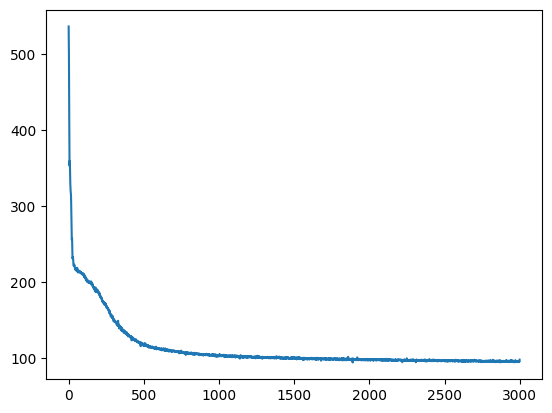

In [7]:
# loss plot
plt.plot(losslog)

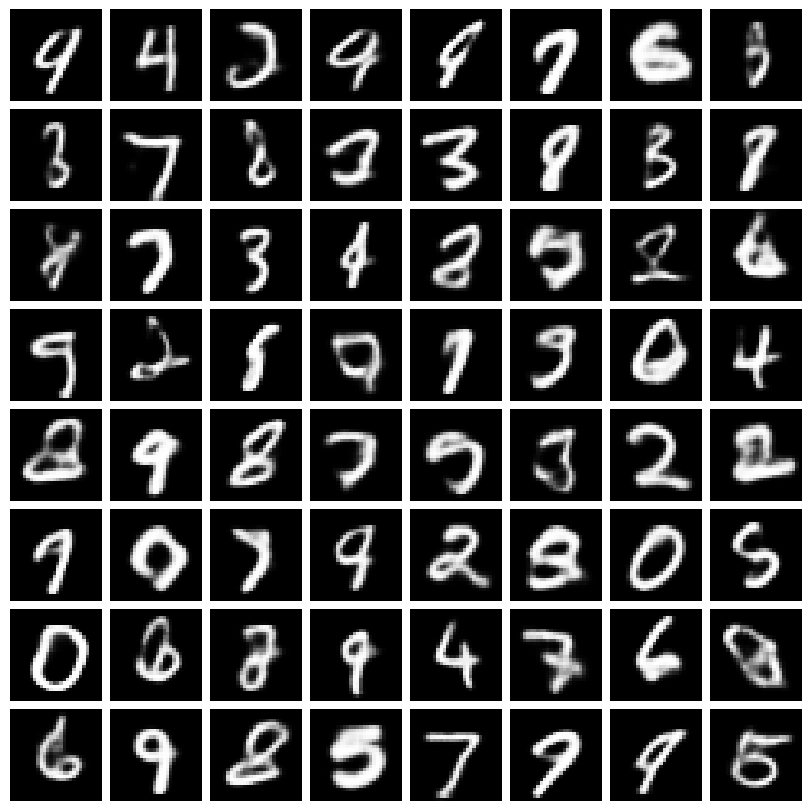

In [8]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad(): 
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [9]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step
FID (1000 images) : 16.363178253173828


In [7]:
with torch.no_grad() :
    mu = model.encoder((dataset1.data.unsqueeze(1)/255.).cuda())[0].cpu()

sigma = torch.cov(mu.cpu().transpose(0, 1))
sup_mean = torch.mean(mu.cpu(), dim=0)

# sampling from the sup_mean, sigma distribution
eps = torch.randn((500,100))
sampled = sup_mean + eps@sigma
eps.shape, sampled.shape

(torch.Size([500, 100]), torch.Size([500, 100]))

In [9]:
with torch.no_grad() :
    generations2 = model.decoder(sampled.cuda()).cpu()
    generations2_eps = model.decoder(eps.cuda()).cpu()

/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


In [12]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

images_from_vae_sampled = np.array(generations2 * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_from_vae_original = np.array(generations2_eps * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid1 = calculate_fid(inc_model, images_from_vae_sampled, images_actual)
fid2 = calculate_fid(inc_model, images_from_vae_original, images_actual)
print(f'Sampled : FID ({images_actual.shape[0]} images) : {fid1}')
print(f'Original : FID ({images_actual.shape[0]} images) : {fid2}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
Sampled : FID (1000 images) : 12.056306838989258
Original : FID (1000 images) : 16.83680534362793


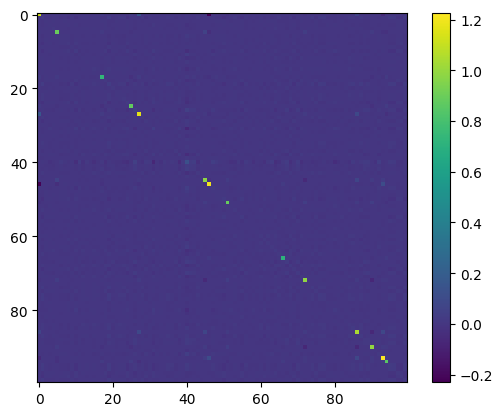

In [17]:
plt.imshow(sigma)
plt.colorbar();

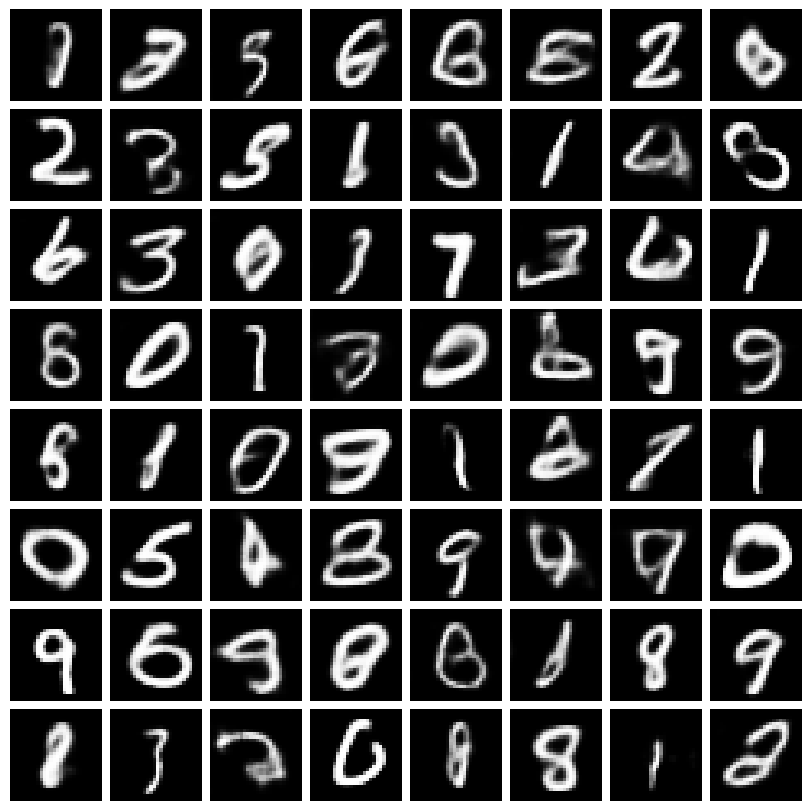

In [19]:
# showing images generated from the sampled distribution

## generate new images by VAE

n_cols, n_rows = 8, 8
generated_imgs = np.array(generations2[:64] * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [10]:
torch.save(model, 'models/VAE_base_100d.pt')

In [6]:
model = torch.load('models/VAE_base_100d.pt')

In [7]:
sum([p.numel() for p in model.parameters()])

7558473

In [11]:
# seeing the lower bound on the fid that can be obtained purely by sampling
with torch.no_grad() :
    recons = model((dataset2.data[:500] / 255.).unsqueeze(1).cuda())[0].cpu()

In [12]:
# reconstruction FID

test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

images_from_vae_recons = np.array(recons * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae_recons, images_actual)
print(f'Reconstructed : FID ({images_actual.shape[0]} images) : {fid}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step
Reconstructed : FID (1000 images) : 5.691100120544434


In [8]:
# showing images generated from the sampled distribution

## generate new images by VAE

n_cols, n_rows = 8, 8
generated_imgs = np.array(recons[:64] * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

NameError: name 'recons' is not defined

In [73]:
# trying to perturb a point in the latent space and seeing how the geenration varies
num_points = 64
with torch.no_grad() :
    work_data = dataset1.data[:2].unsqueeze(1) / 255.
    work_latents = model.encoder(work_data)[0]
    point1, point2 = torch.tensor_split(work_latents, 2, dim=0)

    t = torch.linspace(0., 1., num_points)[:, None]
    points = point1 + t*(point2-point1)

    images = model.decoder(points)

with torch.no_grad() :
    work_data = dataset1.data[1:3].unsqueeze(1) / 255.
    work_latents = model.encoder(work_data)[0]
    point1, point2 = torch.tensor_split(work_latents, 2, dim=0)

    t = torch.linspace(0., 1., num_points)[:, None]
    points2 = point1 + t*(point2-point1)

    images2 = model.decoder(points2)

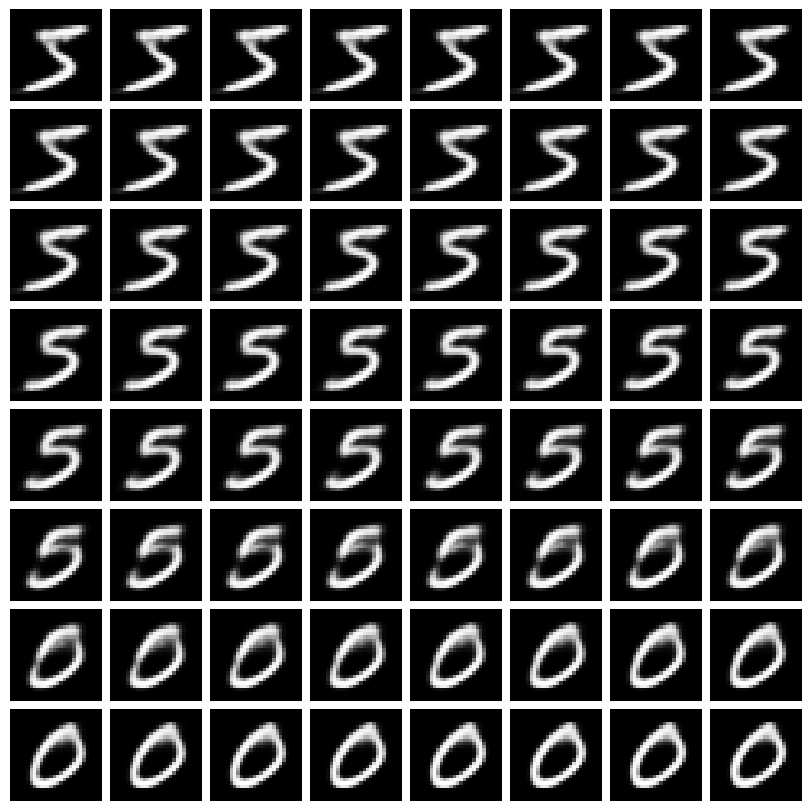

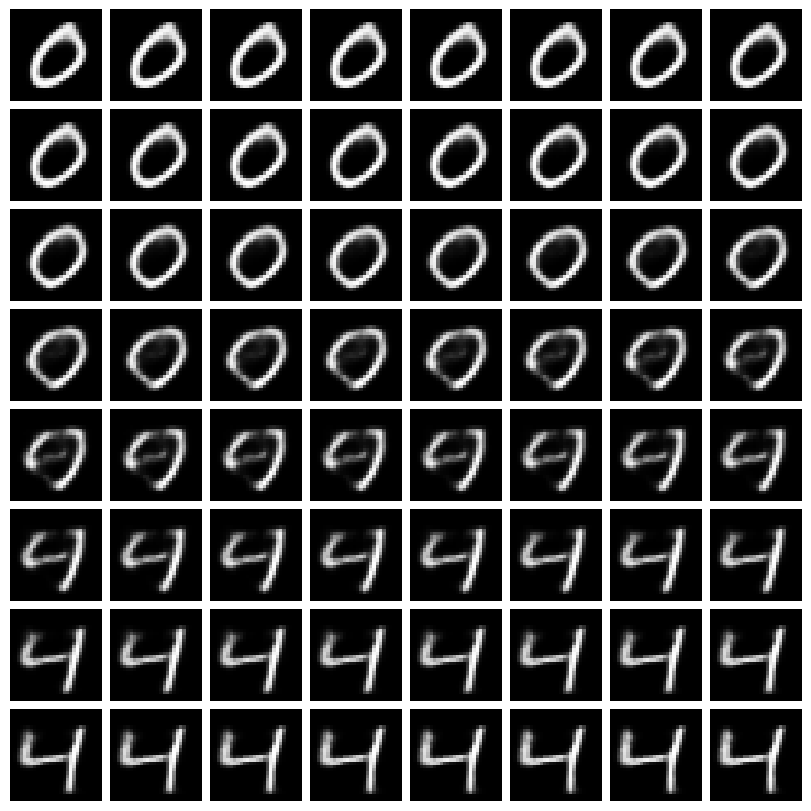

In [74]:
## generate new images by VAE, showing variation

n_cols, n_rows = 8, 8
generated_imgs = np.array(images * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

generated_imgs2 = np.array(images2 * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [75]:
# Tabulating the FID variation as a function of the purturbation

# reconstruction FID

test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fids1 = []
fids2 = []
for i in tqdm(range(num_points)) :
    gens1 = np.array(images[i] * 255, dtype=np.uint8).reshape(1, 1, image_size, image_size)
    gens2 = np.array(images2[i] * 255, dtype=np.uint8).reshape(1, 1, image_size, image_size)
    fid1 = calculate_fid(inc_model, gens1, images_actual, verbose=False)
    fid2 = calculate_fid(inc_model, gens2, images_actual, verbose=False)
    fids1.append(fid1)
    fids2.append(fid2)
    

  0%|          | 0/64 [00:00<?, ?it/s]

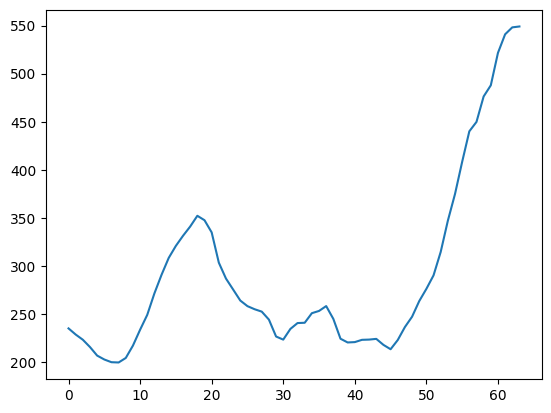

In [78]:
plt.plot(fids2)

In [6]:
model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
model = torch.load('models/VAE_base.pt')

### Trying Langevin MC sampling to see if it improves generations

In [10]:
gauss_var = 1.
# pivot_indices = np.array([1,3,5,12,9,0,62,52,17,22])
pivot_indices = np.arange(100)
pivot_images = dataset1.data[pivot_indices].unsqueeze(1) / 255.
with torch.no_grad() : encodings = model.encoder(pivot_images.to(next(model.parameters()).device))[0].cpu()
pivot_images.shape, encodings.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100, 100]))

In [49]:
# potential function : sum of gaussians
def potential(z, encodings, sigma=gauss_var) :
    z = z.view(-1, encodings.shape[-1])
    ans = 0
    for i in range(len(encodings)) :
        ans += torch.exp(-torch.norm(z-encodings[i], dim=-1) / 2*sigma*sigma)
    return ans

In [50]:
def log_Q(potential, encodings, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=100.):
    burn_in = 10000
    Z0 = torch.randn(1, encodings.shape[-1])
    Zi = Z0
    samples = []
    pbar = tqdm(range(n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi, encodings).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
        if True : #  torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


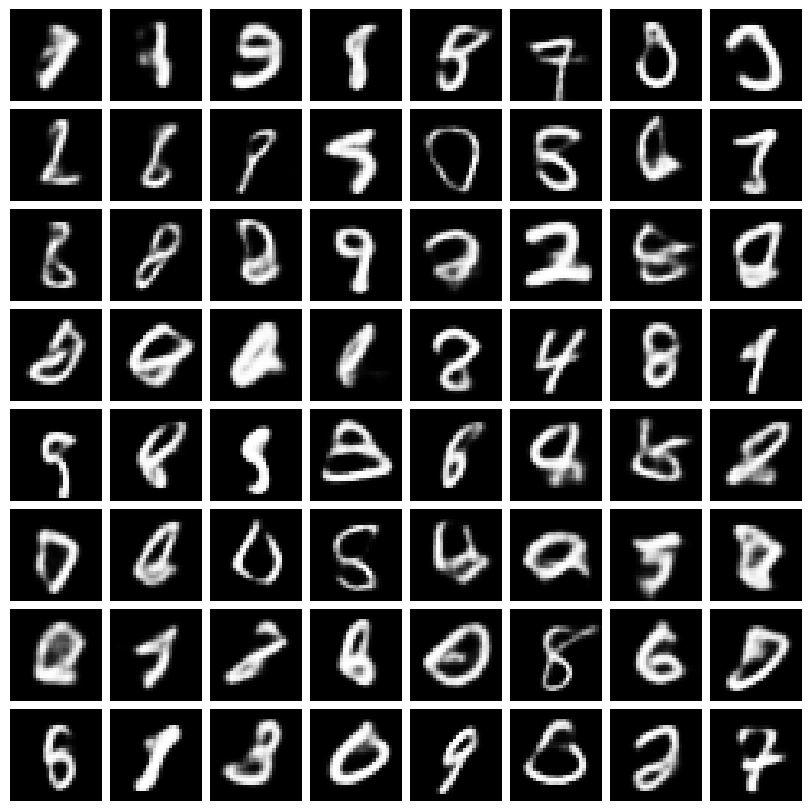

In [9]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad(): 
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

  0%|          | 0/10064 [00:00<?, ?it/s]

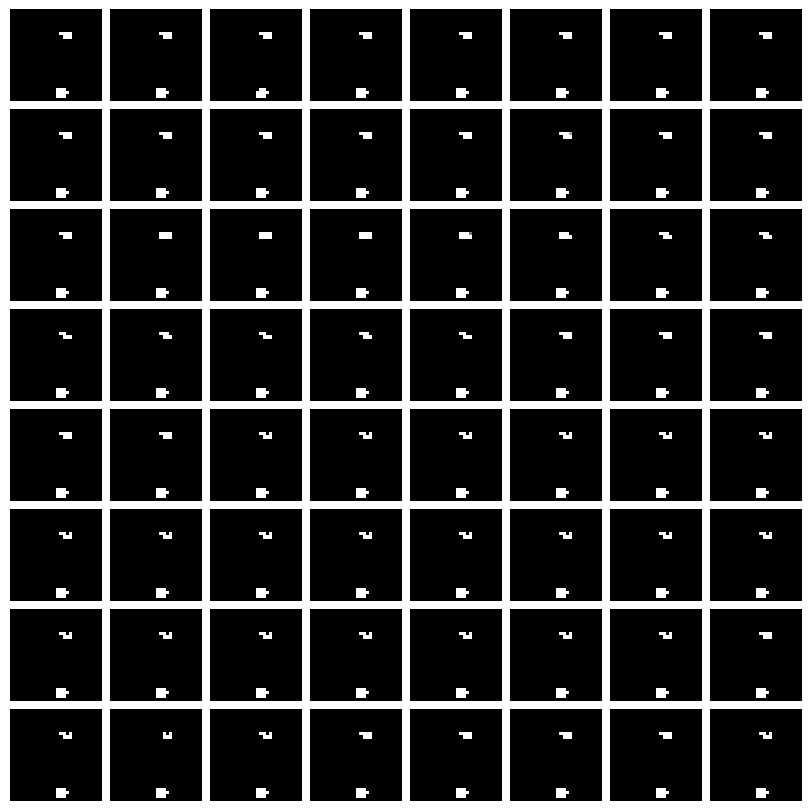

In [51]:
# showing images generated from the sampled distribution
## generate new images by VAE

n_images = 8*8
n_cols, n_rows = 8, 8
latents = metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=n_images)
with torch.no_grad() : images = model.decoder(torch.tensor(latents).to(next(model.decoder.parameters()).device)).cpu()
generated_imgs = np.array(images * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

Some Analysis

In [64]:
labels = dataset1.targets
images = dataset1.data.unsqueeze(1).float()[:1000]
mu, log_var = model.encoder(images.cuda())
latents = model.sample_z(mu, log_var)
generations = model.decoder(latents)

latents = latents.cpu().detach()
generations = generations.cpu().detach()

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latents_transformed = pca.fit_transform(latents.clip(-10000., 10000.))

In [75]:
latents.shape, latents_transformed.shape

(torch.Size([1000, 100]), (1000, 2))

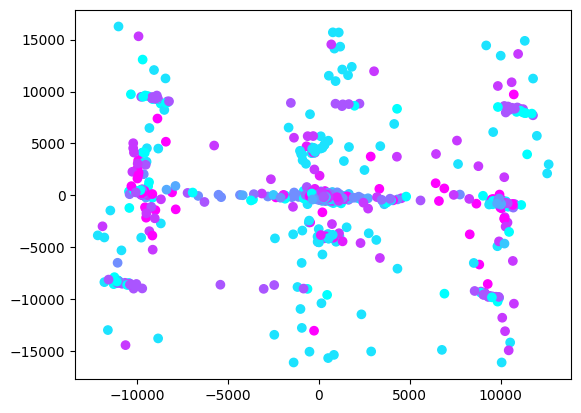

In [76]:
plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=labels[:1000], cmap='cool')
# plt.legend([str(i) for i in range(10)])

## Trying VAE with a very restricted latent space dimension

In [65]:
batch_size = 2056 # 1024
epochs = 100

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 6742917


In [66]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 234.38758850097656
Epoch 5, loss 167.0694580078125
Epoch 10, loss 163.871337890625
Epoch 15, loss 156.96731567382812
Epoch 20, loss 153.3331298828125
Epoch 25, loss 150.103759765625
Epoch 30, loss 148.315185546875
Epoch 35, loss 147.16722106933594
Epoch 40, loss 144.6511688232422
Epoch 45, loss 144.8721466064453
Epoch 50, loss 144.44381713867188
Epoch 55, loss 150.96923828125
Epoch 60, loss 144.34689331054688
Epoch 65, loss 146.93075561523438
Epoch 70, loss 142.10382080078125
Epoch 75, loss 147.1143341064453
Epoch 80, loss 141.11734008789062
Epoch 85, loss 141.02032470703125
Epoch 90, loss 146.0625762939453
Epoch 95, loss 142.59420776367188


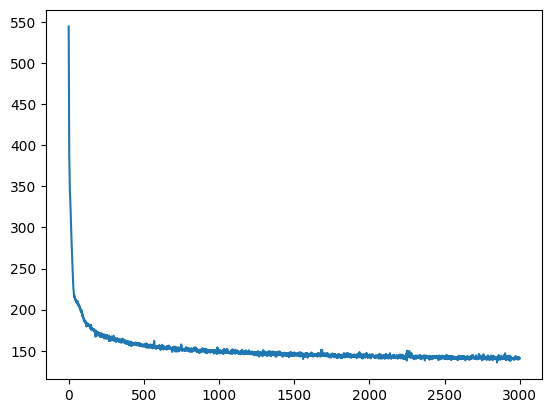

In [67]:
plt.plot(losslog)

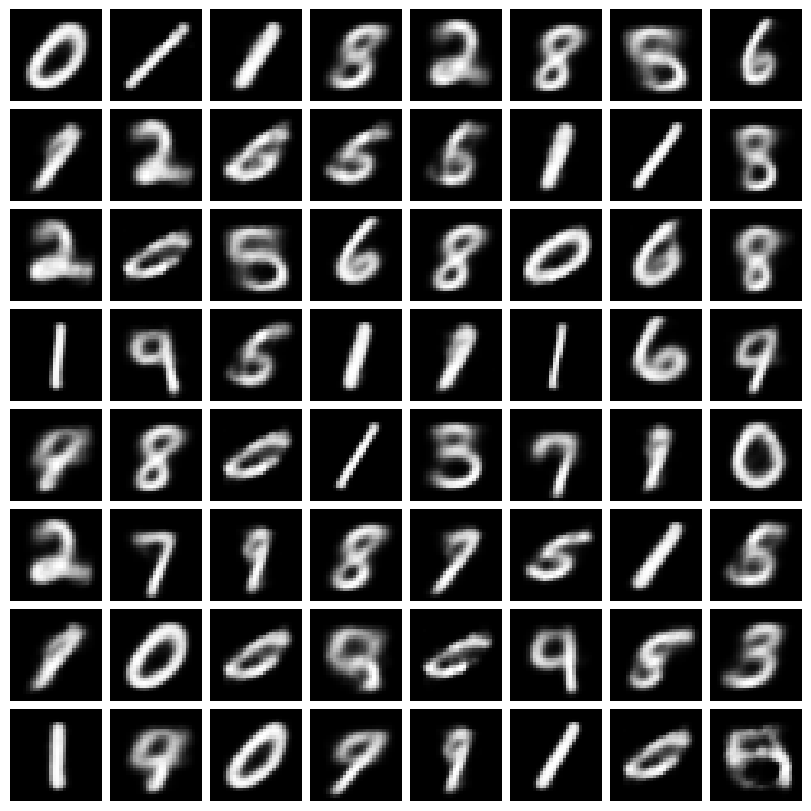

In [68]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad(): 
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [69]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step
FID (1000 images) : 82.37242126464844


In [70]:
labels = dataset1.targets[::60]
images = dataset1.data.unsqueeze(1).float()[::60] / 255.
mu, log_var = model.encoder(images.cuda())
latents = model.sample_z(mu, log_var)
generations = model.decoder(latents)

latents = latents.cpu().detach()
generations = generations.cpu().detach()

In [71]:
images.shape, latents.shape, generations.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 2]),
 torch.Size([1000, 1, 28, 28]))

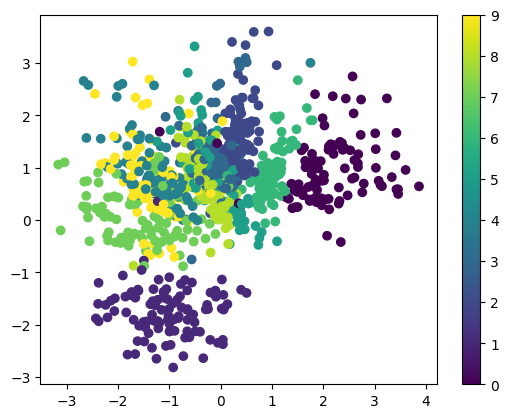

In [72]:
plt.scatter(latents[:,0], latents[:,1], c=labels, cmap='viridis')
plt.colorbar()

In [73]:
torch.save(model, 'models/VAE_mnist_2d.pt')

In [23]:
# trying the sampling strategy on a 2d latent space model

model = torch.load('models/VAE_mnist_2d.pt')

with torch.no_grad() :
    mu = model.encoder((dataset1.data.unsqueeze(1)/255.).cuda())[0].cpu()

sigma = torch.cov(mu.cpu().transpose(0, 1))
sup_mean = torch.mean(mu.cpu(), dim=0)

# sampling from the sup_mean, sigma distribution
eps = torch.randn((500,2))
sampled = sup_mean + eps@sigma
eps.shape, sampled.shape

with torch.no_grad() :
    generations2 = model.decoder(sampled.cuda()).cpu()
    generations2_eps = model.decoder(eps.cuda()).cpu()

test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

images_from_vae_sampled = np.array(generations2 * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_from_vae_original = np.array(generations2_eps * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid1 = calculate_fid(inc_model, images_from_vae_sampled, images_actual)
fid2 = calculate_fid(inc_model, images_from_vae_original, images_actual)
print(f'Sampled : FID ({images_actual.shape[0]} images) : {fid1}')
print(f'Original : FID ({images_actual.shape[0]} images) : {fid2}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step
Sampled : FID (1000 images) : 58.00529479980469
Original : FID (1000 images) : 76.52963256835938


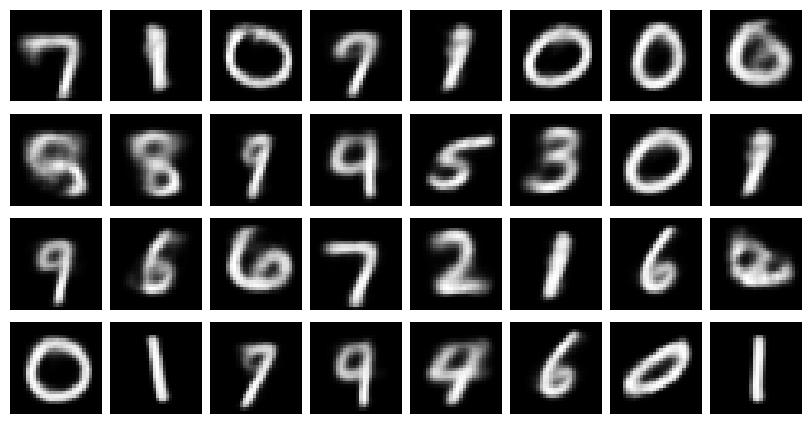

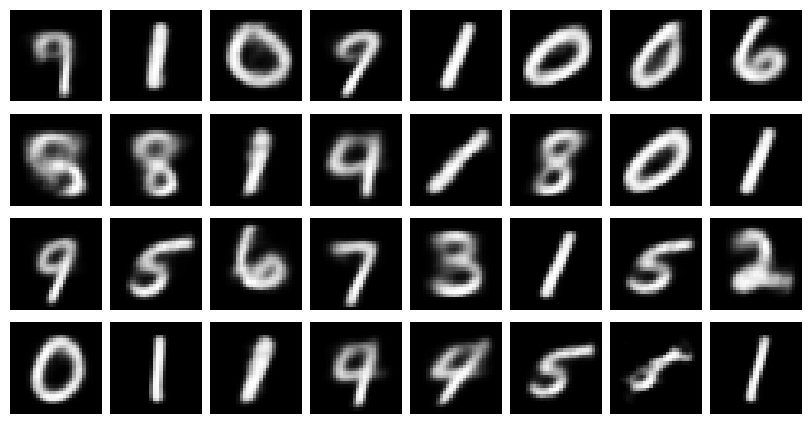

In [29]:
# showing images generated from the sampled distribution

## generate new images by VAE

n_cols, n_rows = 8, 8
generated_imgs = np.array(generations2[:64] * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows//2):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

generated_imgs = np.array(generations2_eps[:64] * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows//2):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

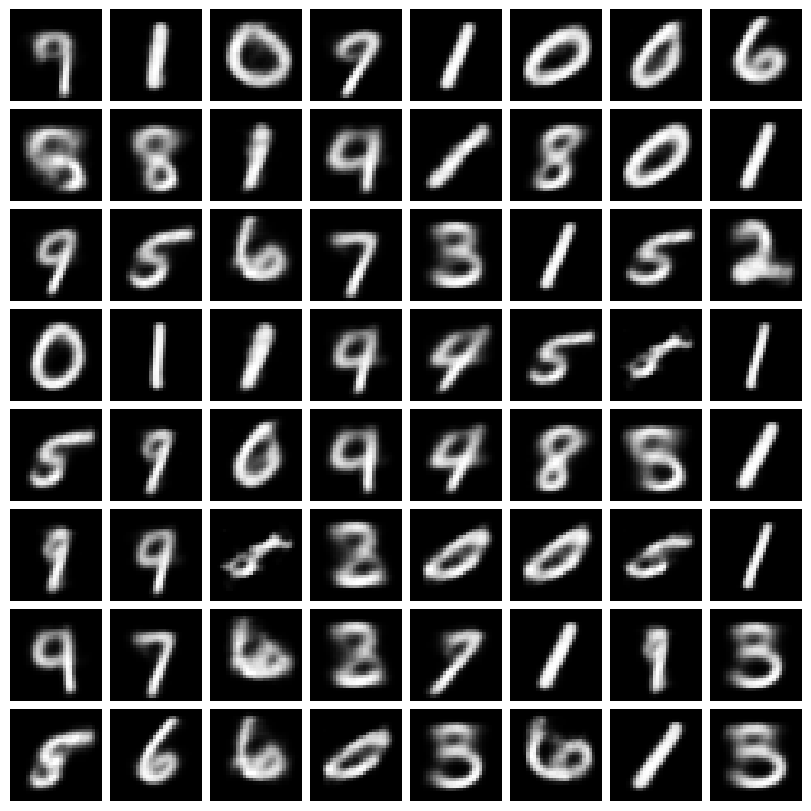

In [25]:
# showing images generated from the eps distribution

## generate new images by VAE

n_cols, n_rows = 8, 8
generated_imgs = np.array(generations2_eps[:64] * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [97]:
# performing the clustering in the latent space domain to enforce disjoint distributions of digits

class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return z, recon, mu, log_var
    
    def compute_loss(self, x, latents, labels, recon, mu, log_var):
        """compute loss of VAE"""

        filt = lambda x : x*torch.pi/5
        targets = filt(labels)
        angles = torch.atan2(latents[:,1], latents[:,0]) + torch.pi
        loss_func = lambda x : (abs(x)-2)*(1. - 1*(-torch.pi/10<=x)*(x<=torch.pi/10))
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        kl_loss += loss_func(angles - targets).mean() 
        
        # recon loss
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        return kl_loss + recon_loss

In [98]:
batch_size = 2056 # 1024
epochs = 100

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 2

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 6742917


In [99]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()
        z, recon, mu, log_var = model(images)
        loss = model.compute_loss(images, z, labels, recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 245.34353637695312
Epoch 5, loss 184.0965118408203
Epoch 10, loss 168.269287109375
Epoch 15, loss 155.5452880859375
Epoch 20, loss 154.38394165039062
Epoch 25, loss 144.95370483398438
Epoch 30, loss 151.07608032226562
Epoch 35, loss 152.19923400878906
Epoch 40, loss 146.75265502929688
Epoch 45, loss 142.3964080810547
Epoch 50, loss 147.75894165039062
Epoch 55, loss 149.16468811035156
Epoch 60, loss 143.84829711914062
Epoch 65, loss 141.70684814453125
Epoch 70, loss 141.73672485351562
Epoch 75, loss 143.11268615722656
Epoch 80, loss 140.53799438476562
Epoch 85, loss 140.20297241210938
Epoch 90, loss 143.24459838867188
Epoch 95, loss 144.510498046875


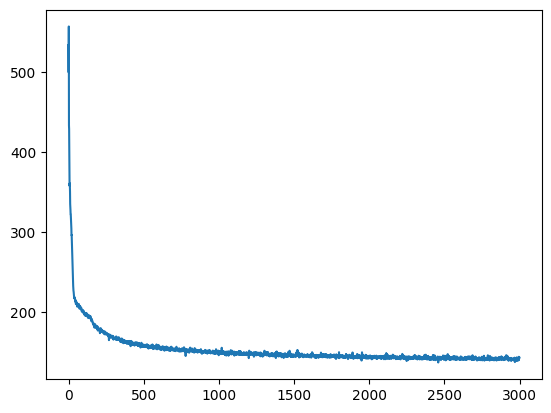

In [101]:
plt.plot(losslog)

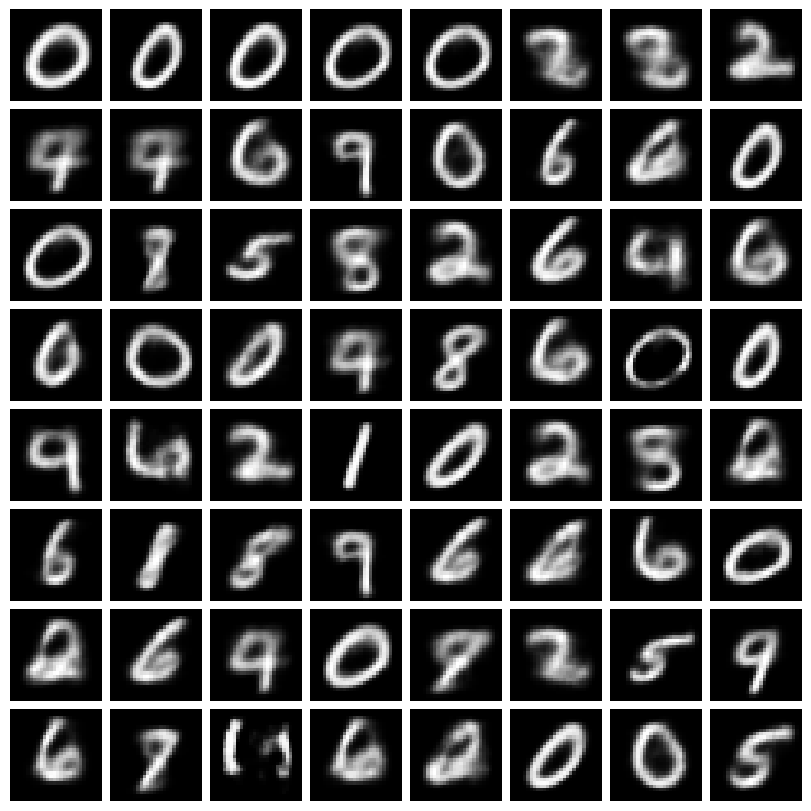

In [102]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad(): 
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

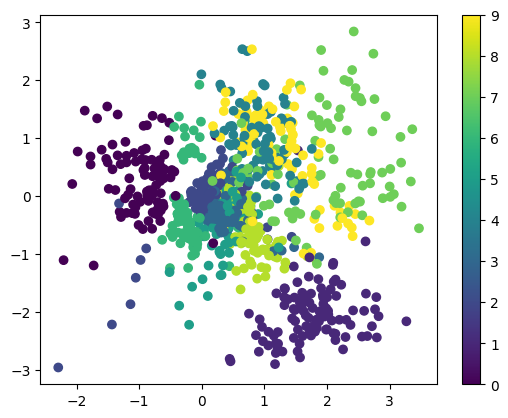

In [103]:
labels = dataset1.targets[::60]
images = dataset1.data.unsqueeze(1).float()[::60] / 255.
mu, log_var = model.encoder(images.cuda())
latents = model.sample_z(mu, log_var)
generations = model.decoder(latents)

latents = latents.cpu().detach()
generations = generations.cpu().detach()

plt.scatter(latents[:,0], latents[:,1], c=labels, cmap='viridis')
plt.colorbar()

In [104]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
FID (1000 images) : 58.63872528076172


In [105]:
torch.save(model, 'models/VAE_mnist_2d_clustered.pt')

In [129]:
# trying the clustering approach with the original latent dimension

# performing the clustering in the latent space domain to enforce disjoint distributions of digits

class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return z, recon, mu, log_var
    
    def compute_loss(self, x, latents, labels, recon, mu, log_var):
        """compute loss of VAE"""
        targets = torch.zeros_like(latents) # (b, 100)
        targets[torch.arange(latents.shape[0]), 10*labels] = 1. # cluster centres

        # KL loss
        kl_loss = (0.5*(log_var.exp() + (mu-targets) ** 2 - 1 - log_var)).sum(1).mean()
        # kl_loss = (latents - targets).norm(dim=-1).mean()
        
        # recon loss
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        return kl_loss + recon_loss

In [130]:
batch_size = 2056 # 1024
epochs = 100

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 7558473


In [131]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()
        z, recon, mu, log_var = model(images)
        loss = model.compute_loss(images, z, labels, recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 241.1635284423828
Epoch 5, loss 194.14752197265625
Epoch 10, loss 145.9525146484375
Epoch 15, loss 124.43368530273438
Epoch 20, loss 117.48116302490234
Epoch 25, loss 109.04158782958984
Epoch 30, loss 105.26644134521484
Epoch 35, loss 103.54344940185547
Epoch 40, loss 101.03543853759766
Epoch 45, loss 100.93984985351562
Epoch 50, loss 100.10194396972656
Epoch 55, loss 99.96929168701172
Epoch 60, loss 99.93531799316406
Epoch 65, loss 97.13824462890625
Epoch 70, loss 96.10147857666016
Epoch 75, loss 99.87138366699219
Epoch 80, loss 97.71015930175781
Epoch 85, loss 97.12556457519531
Epoch 90, loss 97.71263885498047
Epoch 95, loss 96.40135955810547


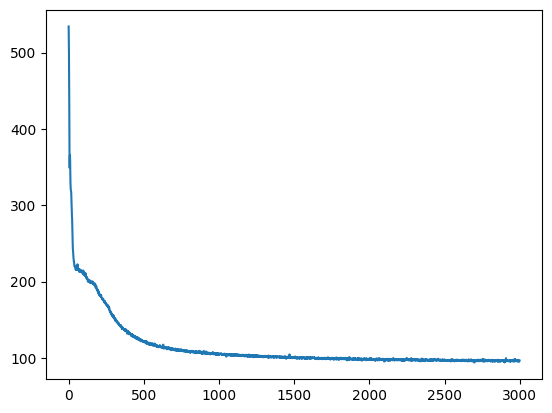

In [132]:
plt.plot(losslog)

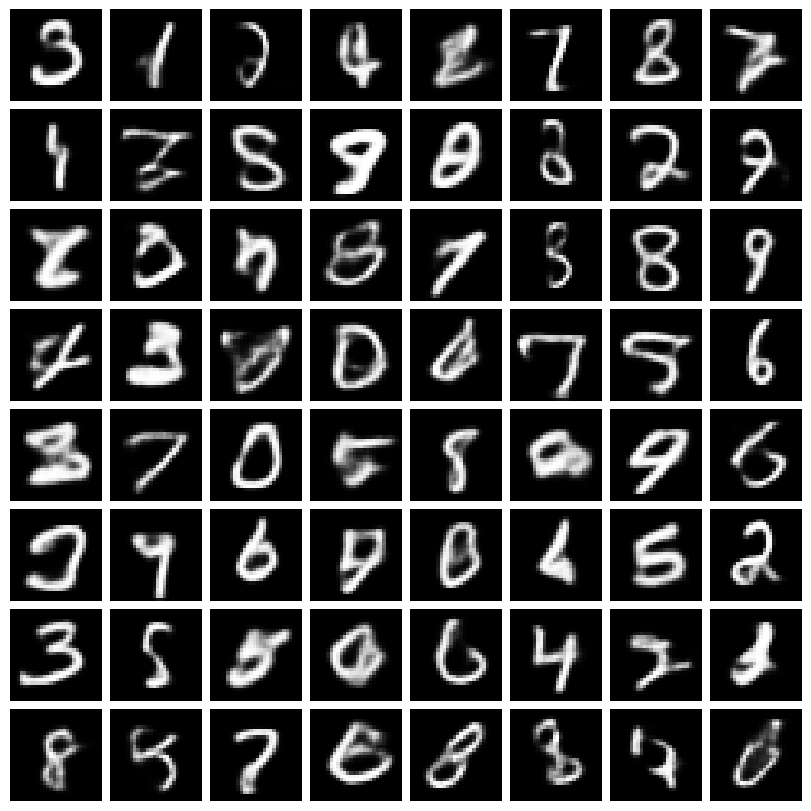

In [133]:
## generate new images by VAE

n_cols, n_rows = 8, 8

sample_zs = torch.randn(n_cols * n_rows, latent_dim)
model.eval()
with torch.no_grad(): 
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()
generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)
for n_col in range(n_cols):
    for n_row in range(n_rows):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [135]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step
FID (1000 images) : 20.36541748046875


In [136]:
labels = dataset1.targets[:1000]
images = dataset1.data.unsqueeze(1).float()[:1000]
mu, log_var = model.encoder(images.cuda())
latents = model.sample_z(mu, log_var)
generations = model.decoder(latents)

latents = latents.cpu().detach()
generations = generations.cpu().detach()

latents.max(), latents.min()

(tensor(inf), tensor(-inf))

In [137]:
mu.max(), mu.min(), log_var.max(), log_var.min()

(tensor(1154.3130, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-643.7485, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(191.3671, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-496.7868, device='cuda:0', grad_fn=<MinBackward1>))

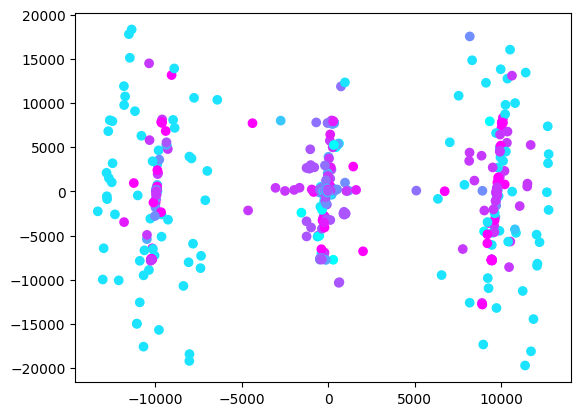

In [116]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latents_transformed = pca.fit_transform(latents.clip(-10000., 10000.))

plt.scatter(latents_transformed[:,0], latents_transformed[:,1], c=labels, cmap='cool')
# plt.legend([str(i) for i in range(10)])

## Trying MNIST with the mu-sigma formulation

In [6]:
model = torch.load('models/VAE_base.pt')

In [7]:
dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform).data

mu, logvar = model.encoder((dataset1/255.).unsqueeze(1).cuda())

In [8]:
mu.shape, logvar.shape

(torch.Size([60000, 784]), torch.Size([60000, 784]))

In [10]:
sigma = torch.cov(mu.cpu().detach().transpose(0, 1))
sup_mean = torch.mean(mu.cpu().detach(), dim=0)

# sampling from the sup_mean, sigma distribution
eps = torch.randn((500,784))
sampled = sup_mean + eps@sigma
sampled.shape

torch.Size([500, 784])

In [18]:
generations2 = model.decoder(sampled.cuda()).cpu().detach()

test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

images_from_vae = np.array(generations2 * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_actual = test_dataset.data[:500].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')



16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step
FID (500 images) : 28.56396484375


In [19]:
generations2_eps = model.decoder(eps.cuda()).cpu().detach()


test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

images_from_vae = np.array(generations2_eps * 255, dtype=np.uint8).reshape(500, 1, image_size, image_size)
images_actual = test_dataset.data[:500].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step
FID (500 images) : 24.193134307861328


## Trying the langevin MC sampling on a latent dim of 2

In [6]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 2 

batch_size = 2056 # 1024
epochs = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data_test', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 6742917


In [7]:
model = torch.load( 'models/mnist_2d_finalRes.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 239.9655303955078
Epoch 5, loss 172.98480224609375
Epoch 10, loss 161.18540954589844
Epoch 15, loss 157.2389678955078
Epoch 20, loss 152.29254150390625
Epoch 25, loss 150.49722290039062
Epoch 30, loss 148.94090270996094
Epoch 35, loss 151.2102813720703
Epoch 40, loss 145.6985626220703
Epoch 45, loss 144.70343017578125
Epoch 50, loss 145.3911895751953
Epoch 55, loss 141.79759216308594
Epoch 60, loss 142.43759155273438
Epoch 65, loss 140.5809326171875
Epoch 70, loss 145.1379852294922
Epoch 75, loss 145.18150329589844
Epoch 80, loss 139.57667541503906
Epoch 85, loss 139.9215545654297
Epoch 90, loss 139.16932678222656
Epoch 95, loss 140.44468688964844


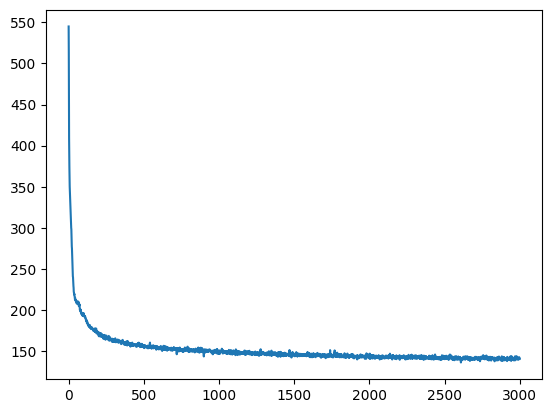

In [72]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

plt.plot(losslog)

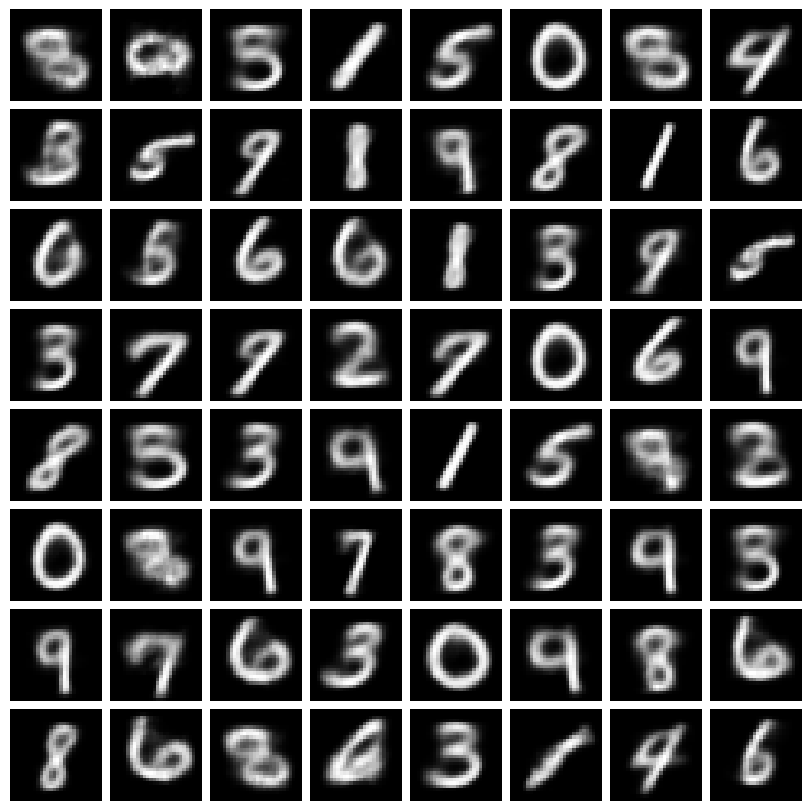

In [74]:
# generating by sampling from N(0, I)
## generate new images by VAE, sampling from N(0,I)
sample_zs = torch.randn(64, latent_dim).to('cuda:0')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [75]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step
FID (1000 images) : 77.79915618896484


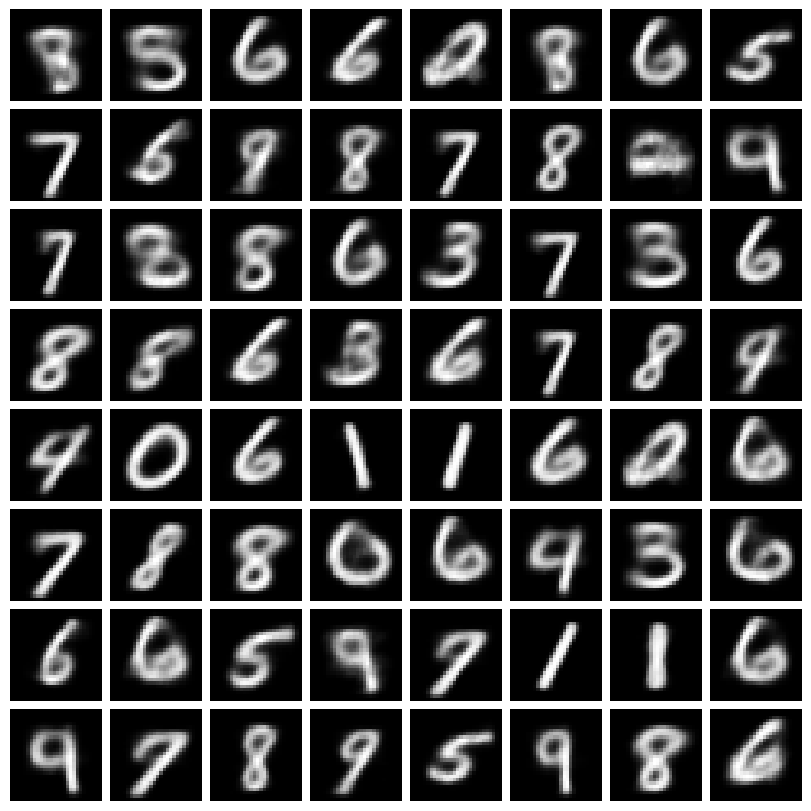

In [76]:
# sampling from N(mu, sigma)
import scipy

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader))[0].cuda(0))[0].cpu()
mu = pivots.mean(dim=0, keepdims=True)
sigma = scipy.linalg.sqrtm(pivots.transpose(0,1).cov())
sample_zs = (mu + torch.randn(64, latent_dim)@sigma).to('cuda:0')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [77]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = (mu + torch.randn(1000, latent_dim)@sigma).to('cuda:0')
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
FID (1000 images) : 74.4989013671875


In [78]:
# sampling from Langevin MC

## sampling from langevin MC

gauss_std = 1/3

def potential(z, encodings, sigma=gauss_std, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).max(-1).values
    if pot : return -torch.log(ans)
    return ans

def log_Q(potential, encodings, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=0.001, k=50):
    burn_in = 10000
    weight = 10.
    Z0 = torch.tensor([2., 0.]).view(1,-1) # torch.randn(1, encodings.shape[-1])
    Zi = Z0
    samples = []
    grads = []
    acc = []
    pbar = tqdm(range(k*n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi, encodings).mean()
        grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
        prop_Zi = Zi.detach() - step * weight *grad + np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi; acc.append(1)
        else : acc.append(0)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in::k], grads, acc, np.concatenate(samples, 0)[:burn_in]

  0%|          | 0/210000 [00:00<?, ?it/s]

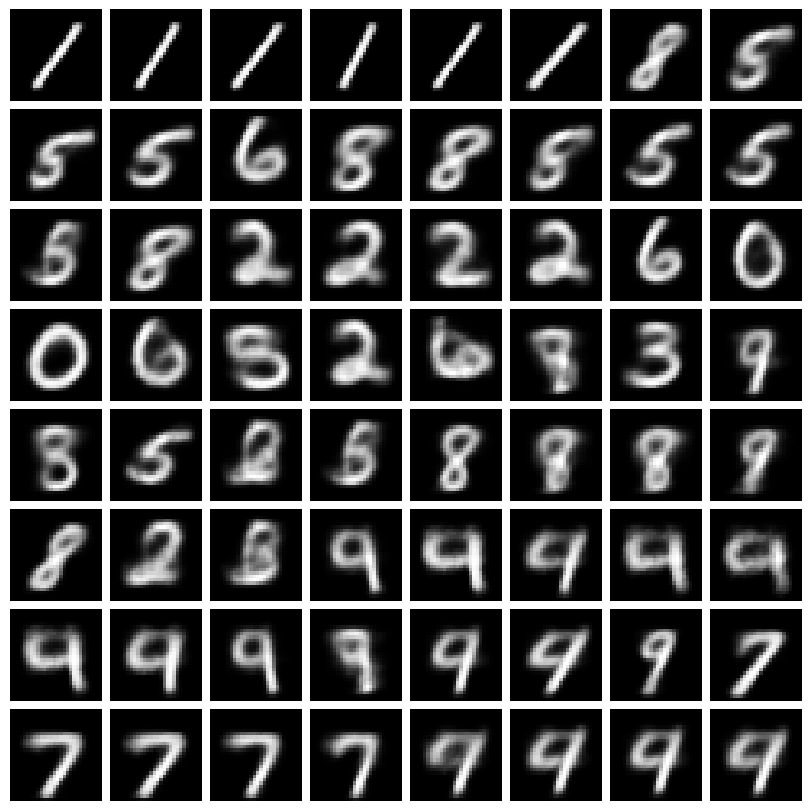

In [83]:
latents, grads, acc, burns = metropolis_adjusted_langevin_algorithm(potential, pivots, n_samples=1000, k=200)

model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(torch.tensor(latents, device='cuda:0'))
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs[1000-64:] * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [84]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
with torch.no_grad():
    generated_imgs = model.decoder(torch.tensor(latents).cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
FID (1000 images) : 67.13260650634766


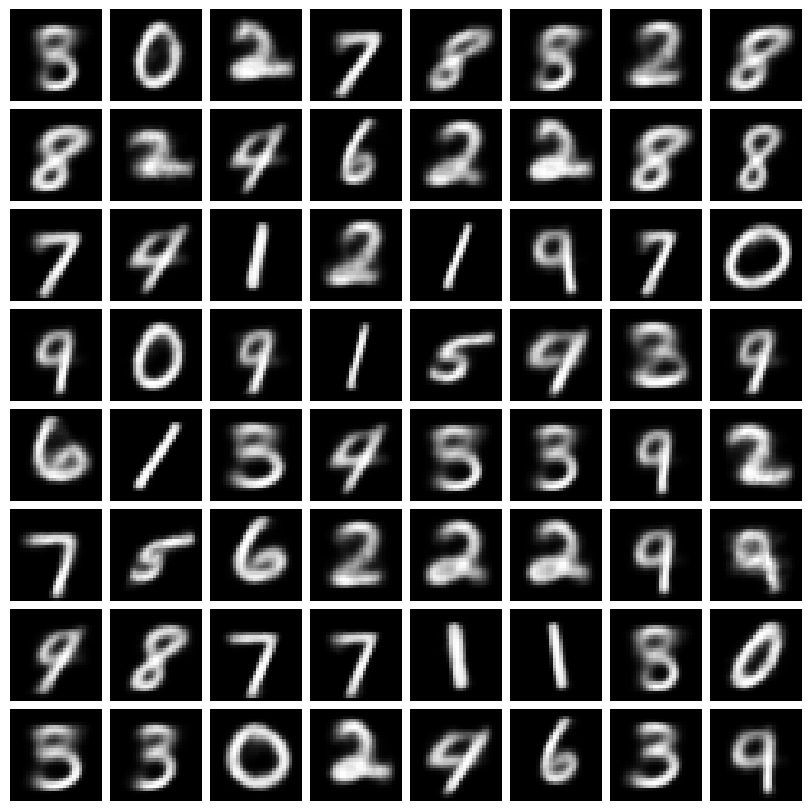

In [81]:
## baselines : reconstruvtions
with torch.no_grad():
    pivots = model.encoder(next(iter(train_loader))[0].cuda(0))[0].cpu()
    generated_imgs = model.decoder(pivots.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs[:64] * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [82]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()
generated_imgs = np.array(generated_imgs[:1000] * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)

fid = calculate_fid(inc_model, generated_imgs, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step
FID (1000 images) : 64.85608673095703


In [48]:
latents.shape, pivots.shape

(torch.Size([2056, 1, 28, 28]), torch.Size([2056, 2]))

In [86]:
torch.save(model, 'models/mnist_2d_finalRes.pt')

In [9]:
pivots.shape

torch.Size([2056, 2])

In [7]:
next(iter(train_loader))[0].shape

torch.Size([2056, 1, 28, 28])

In [10]:
next(iter(model.parameters())).device

device(type='cuda', index=0)

In [15]:
with torch.no_grad() : pivots = model.encoder((next(iter(train_loader))[0]).cuda(0))[0].cpu()
distances = [(one-two).norm().item() for one in pivots for two in pivots if not one.equal(two)]

(array([3.3400e+02, 1.0860e+03, 1.6460e+03, 2.3720e+03, 2.7540e+03,
        3.5180e+03, 4.0260e+03, 4.5700e+03, 4.9380e+03, 5.6380e+03,
        6.1500e+03, 6.8200e+03, 7.2240e+03, 7.5740e+03, 8.0660e+03,
        8.8420e+03, 8.9960e+03, 9.7420e+03, 9.8120e+03, 9.9740e+03,
        1.0954e+04, 1.1084e+04, 1.1628e+04, 1.1932e+04, 1.2238e+04,
        1.2170e+04, 1.2960e+04, 1.3236e+04, 1.3296e+04, 1.3972e+04,
        1.4214e+04, 1.3788e+04, 1.4326e+04, 1.4886e+04, 1.5230e+04,
        1.5364e+04, 1.5432e+04, 1.5974e+04, 1.6138e+04, 1.6220e+04,
        1.6326e+04, 1.6512e+04, 1.6646e+04, 1.7246e+04, 1.7130e+04,
        1.7402e+04, 1.7672e+04, 1.7932e+04, 1.7982e+04, 1.8320e+04,
        1.8444e+04, 1.8578e+04, 1.8876e+04, 1.8988e+04, 1.9278e+04,
        1.9252e+04, 1.8790e+04, 1.9460e+04, 1.9636e+04, 1.9916e+04,
        2.0178e+04, 1.9930e+04, 2.0490e+04, 2.0240e+04, 2.0268e+04,
        2.0948e+04, 2.1100e+04, 2.1298e+04, 2.1152e+04, 2.1622e+04,
        2.1672e+04, 2.1276e+04, 2.1726e+04, 2.17

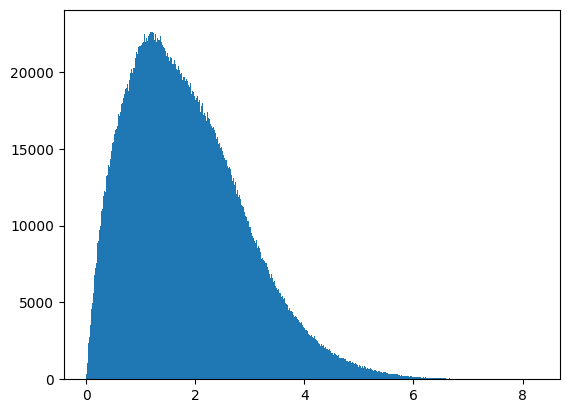

In [16]:
plt.hist(distances, bins=600)

## MNIST 100d/10d latent langevin

In [18]:
x = torch.rand(1, 1, 28, 28)

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 10 # trying with 10

batch_size = 2056 # 1024
epochs = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

transform=transforms.Compose([
    transforms.ToTensor()
])

dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data_test', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 6809493


  0%|          | 0/100 [00:00<?, ?it/s]

/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, loss 298.8707580566406
Epoch 5, loss 194.71420288085938
Epoch 10, loss 139.7412872314453
Epoch 15, loss 122.47007751464844
Epoch 20, loss 110.44486999511719
Epoch 25, loss 106.63299560546875
Epoch 30, loss 106.91083526611328
Epoch 35, loss 104.71638488769531
Epoch 40, loss 102.62640380859375
Epoch 45, loss 102.68440246582031
Epoch 50, loss 101.04405212402344
Epoch 55, loss 96.92579650878906
Epoch 60, loss 101.44757080078125
Epoch 65, loss 99.65667724609375
Epoch 70, loss 101.07630920410156
Epoch 75, loss 100.63395690917969
Epoch 80, loss 100.00062561035156
Epoch 85, loss 103.15306091308594
Epoch 90, loss 98.02839660644531
Epoch 95, loss 96.60859680175781


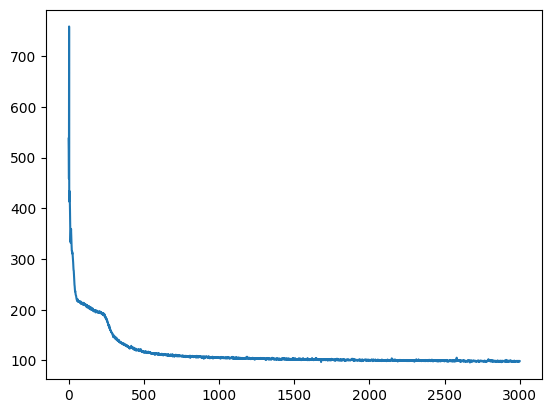

In [19]:
losslog = []
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')

plt.plot(losslog)

In [20]:
torch.save(model, 'models/mnist_10d_finalRes.pt')

In [17]:
model = torch.load('models/mnist_100d_finalRes.pt')

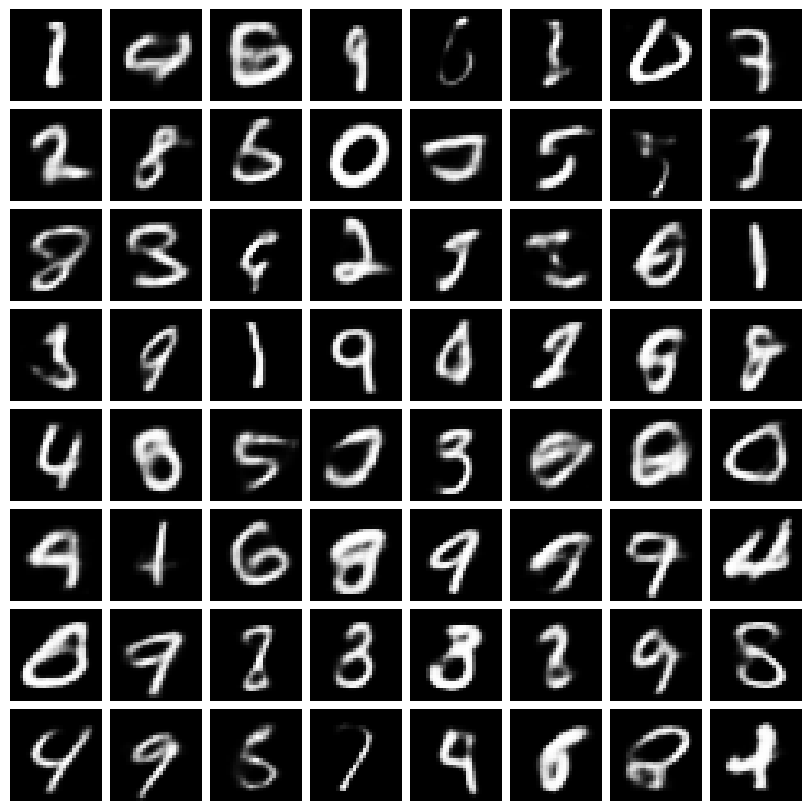

In [21]:
# generating by sampling from N(0, I)
## generate new images by VAE, sampling from N(0,I)
sample_zs = torch.randn(64, latent_dim).to(device)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [22]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step
FID (1000 images) : 17.59340476989746


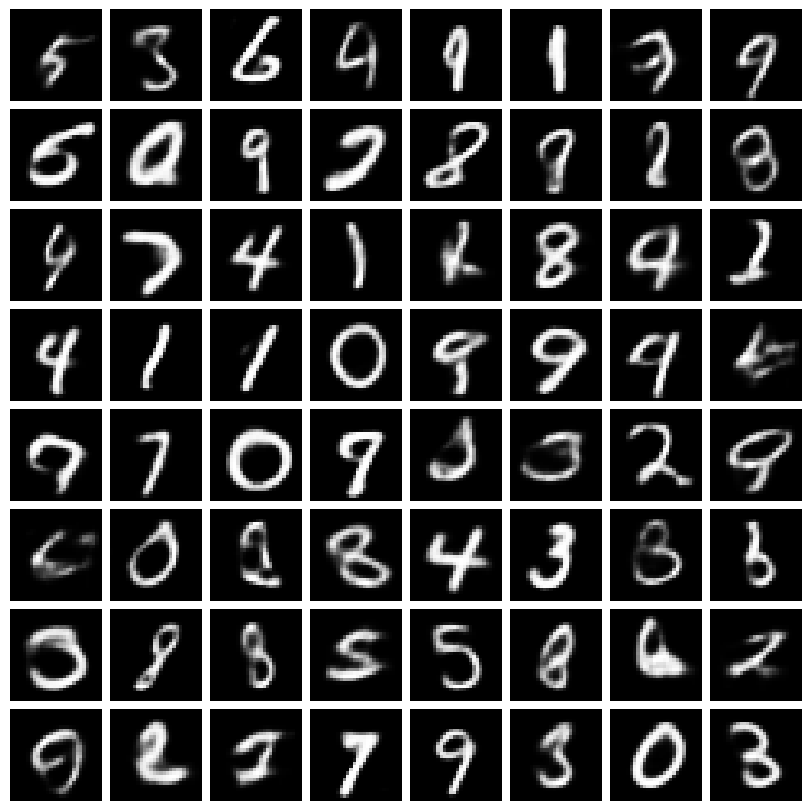

In [23]:
# sampling from N(mu, sigma)
import scipy

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader))[0].cuda(0))[0].cpu()
mu = pivots.mean(dim=0, keepdims=True)
sigma = scipy.linalg.sqrtm(pivots.transpose(0,1).cov()).real
sample_zs = (mu + torch.randn(64, latent_dim)@sigma).to('cuda:0')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [24]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = (mu + torch.randn(1000, latent_dim)@sigma).to('cuda:0')
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = test_dataset.data[:1000].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step
FID (1000 images) : 16.198801040649414


  0%|          | 0/29200 [00:00<?, ?it/s]

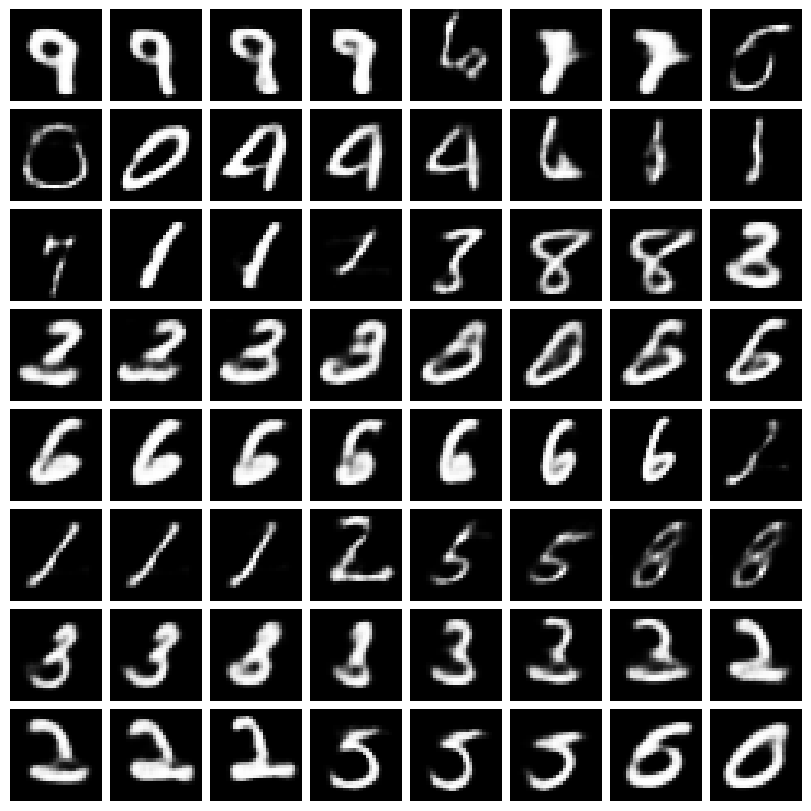

In [62]:
## sampling from langevin MC

#### HPARAMS ####
GAUSE_STD = 2.
STEP = 0.1
WEIGHT = 1
K = 300
#################

def potential(z, encodings, sigma=GAUSE_STD, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).max(-1).values
    if pot : return -torch.log(ans)
    return ans

def log_Q(potential, encodings, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=0.001, k=50, use_conf=False):
    burn_in = 10000
    weight = WEIGHT
    Z0 = torch.randn(1, encodings.shape[-1])
    THRESH = 0.6
    Zi = Z0
    samples = []
    sample_conf = []
    grads = []
    acc = []
    pbar = tqdm(range(k*n_samples + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi, encodings).mean()
        grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
        prop_Zi = Zi.detach() - step * weight *grad + np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi; acc.append(1)
        else : acc.append(0)
        samples.append(Zi.detach().numpy())
        if use_conf : sample_conf.append(potential(Zi.detach(), encodings, pot=False))
    # sampling using a confidence parameter
    if use_conf :
        returnable = []
        for i, samp in enumerate(samples) :
            if i>burn_in and sample_conf[i]>=THRESH : returnable.append(samp)
            if len(returnable)>=n_samples : break
        return np.concatenate(returnable, 0), grads, acc, np.concatenate(samples, 0)[:burn_in], sample_conf
    return np.concatenate(samples, 0)[burn_in::k], grads, acc, np.concatenate(samples, 0)[:burn_in], sample_conf

# with torch.no_grad() : pivots = model.encoder((test_dataset.data.unsqueeze(1)/255.).cuda(0))[0].cpu(); print(pivots.shape)
latents, grads, acc, burns, confs = metropolis_adjusted_langevin_algorithm(potential, pivots, n_samples=64, k=K, step=STEP, use_conf=True) # change 64 to 1000 later

model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(torch.tensor(latents, device='cuda:0'))
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs[:64] * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")

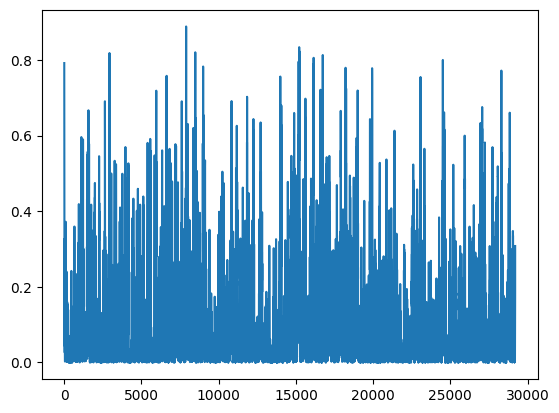

In [63]:
plt.plot(confs)

In [64]:
latents.shape, burns.shape, pivots.shape

((64, 10), (10000, 10), torch.Size([2056, 10]))

In [65]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
low_pivots = pca.fit_transform(pivots)
low_burns = pca.transform(burns)
low_latents = pca.transform(latents)

In [66]:
low_pivots.shape, low_burns.shape, low_latents.shape

((2056, 2), (10000, 2), (64, 2))

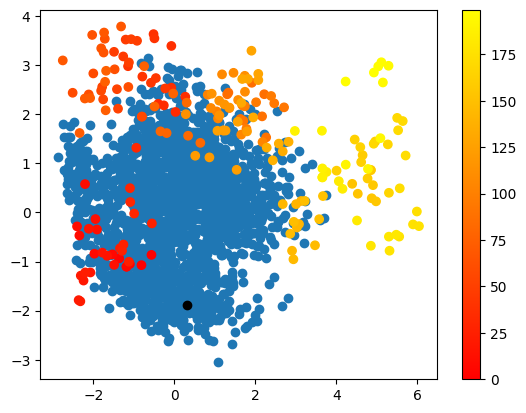

In [67]:
plt.scatter(*low_pivots.transpose())
plt.scatter(*low_burns[:200].transpose(), c=np.arange(200), cmap='autumn')
plt.colorbar()
plt.scatter(*low_pivots[:1].transpose(), color='black')

In [68]:
sum(acc)/len(acc), sum(acc), len(acc)

(0.9826369863013699, 28693, 29200)

In [71]:
pivots.shape

torch.Size([10000, 100])

In [72]:
pivots[:1].shape

torch.Size([1, 100])

In [148]:
grads

[tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]]),
 tensor([[-0.5782, -0.4484, -0.1815, -0.0045,  0.0797, -0.1665,  0.5500,  0.2020,
           0.0502,  0.4885,  0.2583, -0.1487, -0.2397,  0.0569,  0.0311, -0.1642,
          -0.0711,  0.2002,  0.1504, -0.2160, -0.0534,  0.0577,  0.1615, -0.6040,
           0.0788,  0.3220,  0.9027, -0.1683, -0.3230,  0.1117,  0.2967, -0.2153,
          -0.2357,  0.0096,  0.1697, -0.0283,  0.1541, -0.2462, -0.1552,  0.2029,
           0.0737,  0.3346,  0.7442,  0.2242, -0.1326, -0.2358,  0.0427,  0.2029,
           0.4900, -0.0924, -0.1621,  0.0574,  0.3715, 

In [69]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
with torch.no_grad():
    generated_imgs = model.decoder(torch.tensor(latents).cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(64, 1, image_size, image_size)
images_actual = test_dataset.data[:64].unsqueeze(1).numpy()

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
FID (64 images) : 59.68911361694336


In [26]:
pivots.shape

torch.Size([2056, 10])

In [27]:
distances = [(one-two).norm() for one in pivots for two in pivots if not one.equal(two)]

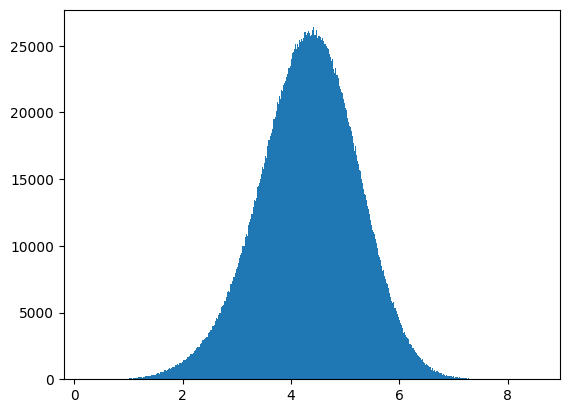

In [28]:
plt.hist(distances, bins=600);

## Training without KL loss, with augmentations

In [13]:
class VAE(nn.Module):
    """VAE"""
    
    def __init__(self, image_size, input_dim, conv_dims, fc_dim, latent_dim):
        super().__init__()
        
        self.encoder = Encoder(image_size, input_dim, conv_dims, fc_dim, latent_dim)
        self.decoder = Decoder(latent_dim, image_size, conv_dims, input_dim)
        
    def sample_z(self, mu, log_var):
        """sample z by reparameterization trick"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sample_z(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var
    
    def compute_loss(self, x, recon, mu, log_var):
        """compute loss of VAE"""
        
        # KL loss
        kl_loss = (0.5*(log_var.exp() + mu ** 2 - 1 - log_var)).sum(1).mean()
        
        # recon loss
        x = x.clip(min=0., max=1.)
        recon_loss = F.binary_cross_entropy(recon, x, reduction="none").sum([1, 2, 3]).mean()
        
        return recon_loss

In [14]:
# Augmentations : 
# Random rotations, translation
# some noise

from torchvision.transforms import v2

image_size = 28
conv_dims = [64, 128]
fc_dim = 1024
latent_dim = 10 # trying with 10

batch_size = 32 # 1024
epochs = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'{device=}')

transform=v2.Compose([
    transforms.ToTensor(),
    v2.RandomAffine(degrees=20, translate=(0.2,0.2)),
    v2.RandomZoomOut(side_range=(1.,1.)),
    transforms.Resize(image_size)
])

dataset1 = datasets.MNIST('data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('data_test', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(image_size, 1, conv_dims, fc_dim, latent_dim).to(device)
# model = torch.compile(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

print('params', sum([p.numel() for p in model.parameters()]))

device='cuda:0'
params 6809493


In [7]:
model = torch.load('models/mnist_10d_withAug.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

/home/ashameem/miniconda3/envs/ddpms/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, loss 130.58001708984375
Epoch 5, loss 96.60334014892578
Epoch 10, loss 93.35842895507812
Epoch 15, loss 85.08934020996094
Epoch 20, loss 87.18544006347656
Epoch 25, loss 92.79094696044922
Epoch 30, loss 96.14894104003906
Epoch 35, loss 95.24871826171875
Epoch 40, loss 85.82858276367188
Epoch 45, loss 82.97509765625
Epoch 50, loss 86.52249145507812
Epoch 55, loss 93.84504699707031
Epoch 60, loss 84.59683227539062
Epoch 65, loss 88.40676879882812
Epoch 70, loss 92.67030334472656
Epoch 75, loss 87.25557708740234
Epoch 80, loss 85.37342834472656
Epoch 85, loss 87.99624633789062
Epoch 90, loss 89.97911834716797
Epoch 95, loss 85.38919067382812


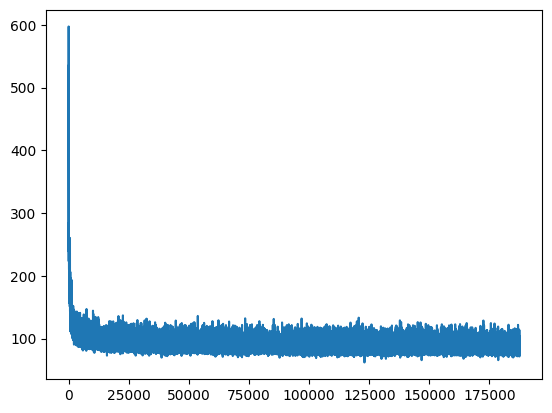

In [15]:
def add_sp_noise(image, p1=0.03, p2=-1) :
    # add pepper with prob p1
    # add salt with prov p2
    if p2==-1 : p2=p1
    image[torch.rand_like(image)<p1] = 0.
    image[torch.rand_like(image)<p2] = 1.
    return image

def mask(image, width=4) :
    x = torch.randint(0, image.shape[-1]-width+1, size=(1,))
    y = torch.randint(0, image.shape[-1]-width+1, size=(1,))
    image[x:x+width, y:y+width] = 0.
    return image


lam = 0.01
losslog = []
p1 = 0.3
p2 = 0.0
for epoch in tqdm(range(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) #; images.requires_grad_()
        recon, mu, log_var = model(images)
        if torch.randn(1)<=p1 : recon, mu, log_var = model(add_sp_noise(images.clone())) # denoising
        elif torch.randn(1)<=p2 : recon, mu, log_var = model(mask(images.clone())) # masking
        else : recon, mu, log_var = model(images)
        loss = model.compute_loss(images, recon, mu, log_var)
        # # adding contractive loss
        # loss += lam*sum([torch.autograd.grad(rec, images, retain_graph=True)[0].norm()**2 for rec in recon.reshape(-1)])**0.5

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad() : losslog.append(loss.item())
    if epoch%5==0 : 
        tqdm.write(f'Epoch {epoch}, loss {loss.item()}')


plt.plot(losslog)

In [16]:
torch.save(model, 'models/mnist_10d_withAug_noZoom_noMask.pt')
# torch.save(model, 'models/mnist_10d_withAug&noise.pt')

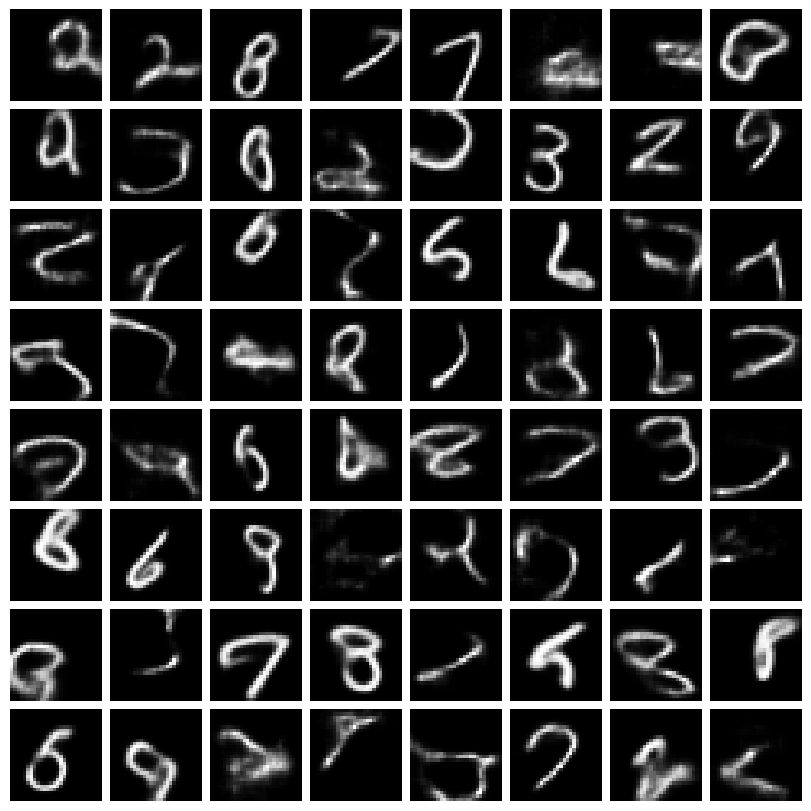

In [17]:
# generating by sampling from N(0, I)
## generate new images by VAE, sampling from N(0,I)
sample_zs = torch.randn(64, latent_dim).to(device)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [31]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = torch.randn(1000, latent_dim)
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = np.uint8(next(iter(loader))[0].numpy()*255)

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 212ms/step
FID (1000 images) : 82.56660461425781


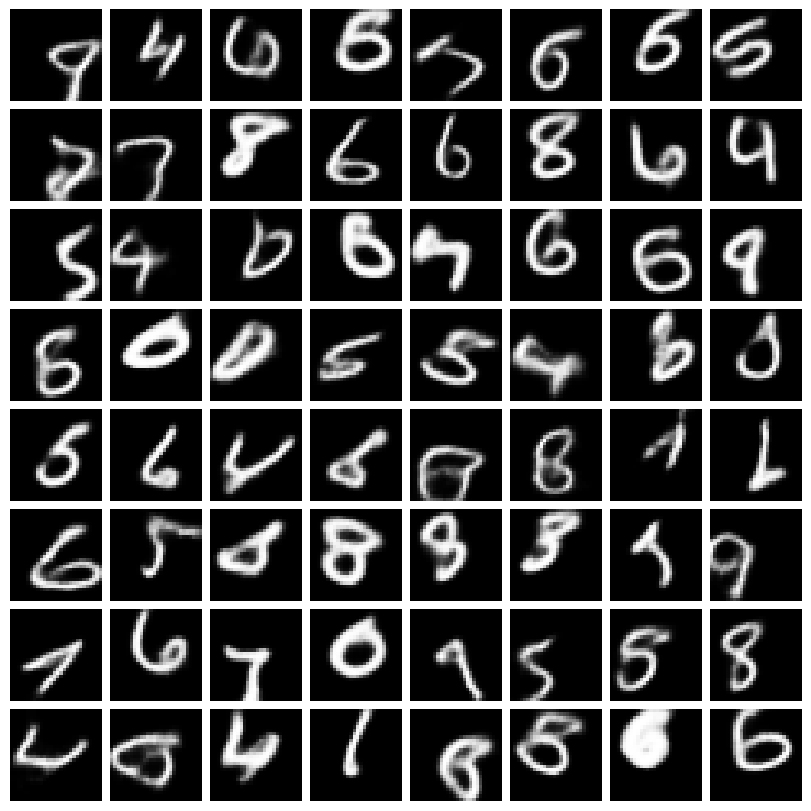

In [24]:
# sampling from N(mu, sigma)
import scipy

with torch.no_grad() : pivots = model.encoder(next(iter(train_loader))[0].cuda(0))[0].cpu()
mu = pivots.mean(dim=0, keepdims=True)
sigma = scipy.linalg.sqrtm(pivots.transpose(0,1).cov()).real
sample_zs = (mu + torch.randn(64, latent_dim)@sigma).to('cuda:0')
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [30]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)

# images_from_ddpm = gaussian_diffusion.sample(model, 28, batch_size=1000, channels=1)[-1]
sample_zs = sample_zs = (mu + torch.randn(1000, latent_dim)@sigma).to('cuda:0')
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = np.uint8(next(iter(loader))[0].numpy()*255)

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
FID (1000 images) : 20.04003143310547


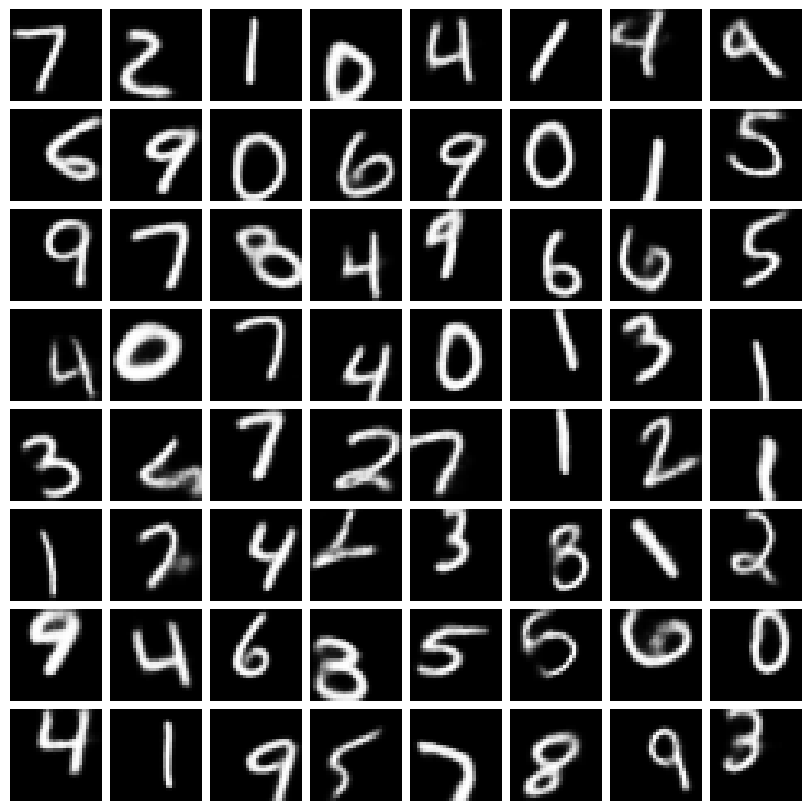

In [26]:
# baseline : reconstructions

test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
with torch.no_grad() :
    pivots = model.encoder(next(iter(loader))[0].cuda(0))[0].cpu()
    recons = model.decoder(pivots[:64].cuda()).cpu()
recons = np.array(recons[:64] * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(recons[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [29]:
test_dataset = datasets.MNIST(root='data_test', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)

with torch.no_grad():
    generated_imgs = model.decoder(pivots[:1000].cuda()).cpu()
    generated_imgs = generated_imgs.cpu().numpy()

images_from_vae = np.array(generated_imgs * 255, dtype=np.uint8).reshape(1000, 1, image_size, image_size)
images_actual = np.uint8(next(iter(loader))[0].numpy()*255)

fid = calculate_fid(inc_model, images_from_vae, images_actual)
print(f'FID ({images_actual.shape[0]} images) : {fid}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step
FID (1000 images) : 11.293880462646484


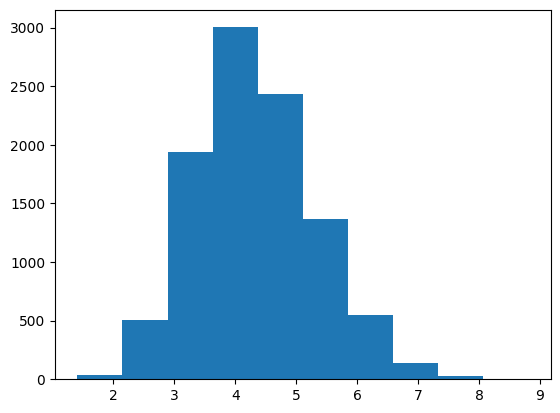

In [32]:
plt.hist(pivots.norm(dim=-1));

torch.Size([60000, 10])


  0%|          | 0/13200 [00:00<?, ?it/s]

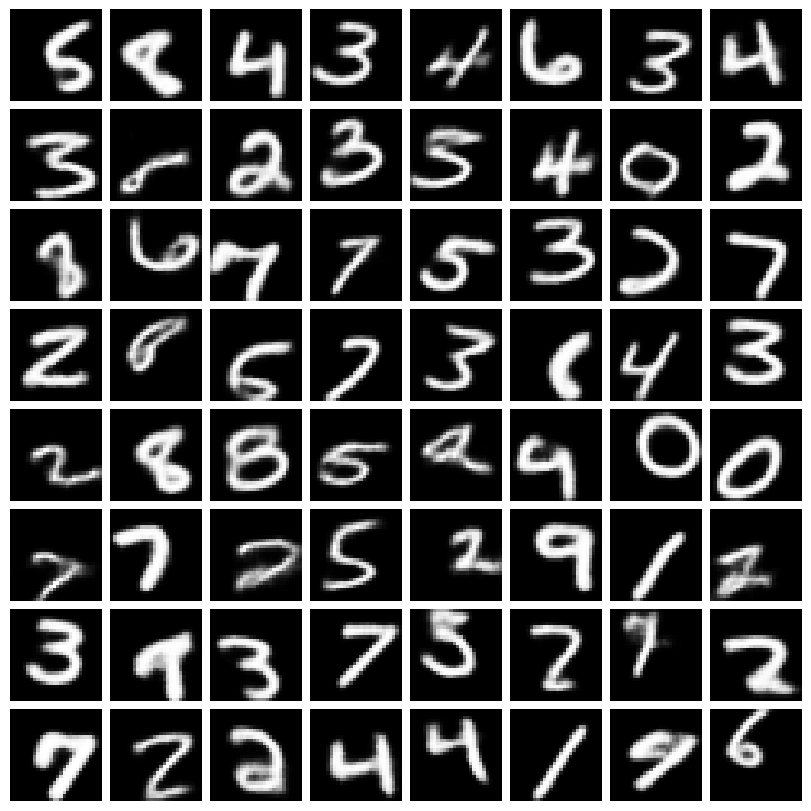

In [33]:
## sampling from langevin MC

#### HPARAMS ####
GAUSE_STD = 1
STEP = 1 # 0.1 # 0.1
WEIGHT = 1
K = 50
#################

def potential(z, encodings, sigma=GAUSE_STD, pot=True) :
    z = z.view(-1, 1, encodings.shape[-1])
    ans = 0
    ans = torch.exp(-torch.norm(z-encodings, dim=-1)**2 / (2*sigma*sigma)).max(-1).values
    if pot : return -torch.log(ans)
    return ans

def log_Q(potential, encodings, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z, encodings).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(potential, encodings, n_samples=100000, step=0.001, k=50, use_conf=False):
    burn_in = 10000
    weight = WEIGHT
    Z0 = torch.randn(1, encodings.shape[-1])
    THRESH = 0.3; c=0; p=1
    Zi = Z0
    samples = []
    returnable = []
    sample_conf = []
    log_ratios = []
    grads = []
    acc = []
    steps = []
    pbar = tqdm(range(k*n_samples + burn_in)) if not use_conf else tqdm(range(burn_in))
    for _ in pbar :
        Zi.requires_grad_()
        u = potential(Zi, encodings).mean()
        grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
        st_one = -step *grad
        st_two = weight * np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
        with torch.no_grad() : 
            if potential(Zi, encodings, pot=False) < 0.9 : st = st_one
            else : st = st_two
        # st = st_one # if torch.randn(1)<p else st_two
        # st /= st.norm()
        # st = st_one + st_two # 3*st_one/st_one.norm() + 3*st_two/st_two.norm()
        prop_Zi = Zi.detach() + st; steps.append(st.norm().item())
        log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                    log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
        log_ratios.append(log_ratio.detach().item())
        if True : # torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi; acc.append(1)
        else : acc.append(0)
        samples.append(Zi.detach().numpy())
        sample_conf.append(potential(Zi.detach(), encodings, pot=False).item())
    if use_conf :
        print('Now Sampling...')
        while True :
            Zi.requires_grad_()
            u = potential(Zi, encodings).mean()
            grad = torch.autograd.grad(u, Zi)[0]; grads.append(grad)
            st_one = -step*grad
            st_two = weight * np.sqrt(2 * step) * torch.randn(1, encodings.shape[-1])
            with torch.no_grad() : 
                if potential(Zi, encodings, pot=False) <0.9 : st = st_one
                else : st = st_two
            # st = st_one + st_two # 3*st_one/st_one.norm() + 3*st_two/st_two.norm()
            # st /= st.norm()
            prop_Zi = Zi.detach() + st; steps.append(st.norm().item())
            log_ratio = -potential(prop_Zi, encodings).mean() + potential(Zi, encodings).mean() +\
                        log_Q(potential, encodings, Zi, prop_Zi, step) - log_Q(potential, encodings, prop_Zi, Zi, step)
            log_ratios.append(log_ratio.detach().item())
            if torch.rand(1) < torch.exp(log_ratio):
                Zi = prop_Zi; acc.append(1)
            else : acc.append(0)
            if potential(Zi.detach(), encodings, pot=False)>=THRESH : returnable.append(Zi.detach().numpy()); c+=1; print(c, end=' : ')
            sample_conf.append(potential(Zi.detach(), encodings, pot=False).item())
            if c>=n_samples : break
        return np.concatenate(returnable, 0), grads, acc, np.concatenate(samples, 0)[:burn_in], sample_conf, steps, log_ratios
    return np.concatenate(samples, 0)[burn_in::k], grads, acc, np.concatenate(samples, 0)[:burn_in], sample_conf, steps, log_ratios

with torch.no_grad() : 
    pivot_transform=v2.Compose([
            transforms.ToTensor(),
            v2.RandomAffine(degrees=10, translate=(0.1,0.1)),
            v2.RandomZoomOut(side_range=(1.,1.5)),
            transforms.Resize(image_size)
        ])
    pivot_dataset = datasets.MNIST('data', train=True, download=True,
                       transform=pivot_transform)
    loader = torch.utils.data.DataLoader(pivot_dataset, batch_size=len(pivot_dataset))
    pivots = model.encoder(next(iter(loader))[0].cuda(0))[0].cpu()
    # pivots = model.encoder((test_dataset.data.unsqueeze(1)/255).cuda())[0].cpu()
    # for _ in range(9) :
    #     temp = model.encoder(next(iter(loader))[0].cuda(0))[0].cpu()
    #     pivots = torch.cat((pivots, temp), dim=0)
print(pivots.shape)
latents, grads, acc, burns, confs, steps, log_ratios = metropolis_adjusted_langevin_algorithm(potential, pivots, n_samples=64, k=K, step=STEP, use_conf=False) # change 64 to 1000 later

model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(torch.tensor(latents, device='cuda:0'))
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs[:64] * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")

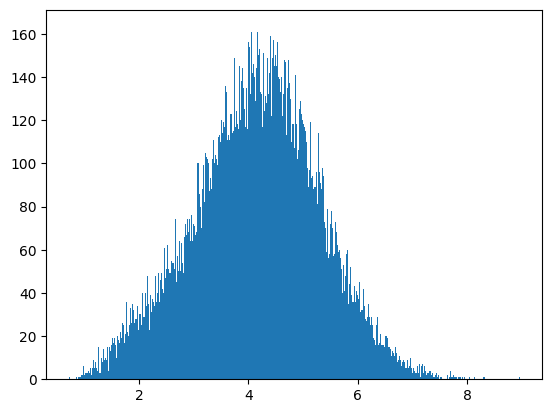

In [44]:
plt.hist(steps, bins=600);

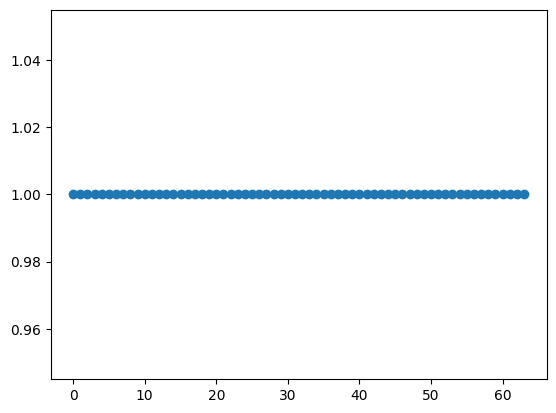

In [35]:
plt.plot(confs[10000:10000+50*64:50], marker='o')

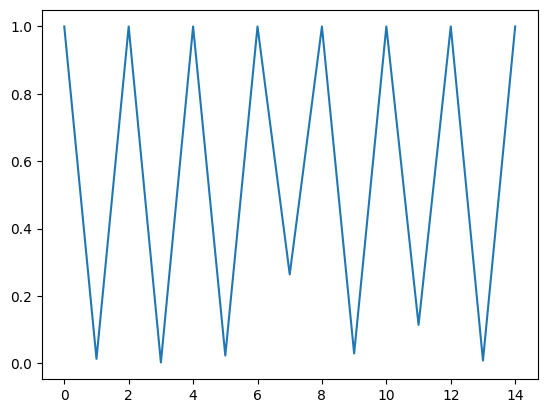

In [36]:
plt.plot(confs[3000:3015])

In [57]:
with torch.no_grad() : 
    pivot_transform=v2.Compose([
            transforms.ToTensor(),
            v2.RandomAffine(degrees=10, translate=(0.1,0.1)),
            v2.RandomZoomOut(side_range=(1.,1.5)),
            transforms.Resize(image_size)
        ])
    pivot_dataset = datasets.MNIST('data', train=True, download=True,
                       transform=pivot_transform)
    loader = torch.utils.data.DataLoader(pivot_dataset, batch_size=len(pivot_dataset))
    pivots = model.encoder(next(iter(loader))[0].cuda(0))[0].cpu()
    # pivots = model.encoder((test_dataset.data.unsqueeze(1)/255).cuda())[0].cpu()
    # for _ in range(9) :
    #     temp = model.encoder(next(iter(loader))[0].cuda(0))[0].cpu()
    #     pivots = torch.cat((pivots, temp), dim=0)
print(pivots.shape)

pivots_walk = pivots[0] + torch.linspace(0, 1, 8)[:,None]*(pivots[1]-pivots[0])[None,:]
for i in range(1, 8) :
    pivots_walk = torch.cat((pivots_walk, pivots[2*i] + torch.linspace(0, 1, 8)[:,None]*(pivots[2*i+1]-pivots[2*i])[None,:]), dim=0)
# pivots_walk = pivots[0] + torch.linspace(0, 1, 8)[:,None]*(pivots[1]-pivots[0])[None,:]
# pivots_walk = pivots[0] + torch.linspace(0, 1, 8)[:,None]*(pivots[1]-pivots[0])[None,:]
# pivots_walk = pivots[0] + torch.linspace(0, 1, 8)[:,None]*(pivots[1]-pivots[0])[None,:]
# pivots_walk = pivots[0] + torch.linspace(0, 1, 8)[:,None]*(pivots[1]-pivots[0])[None,:]
# pivots_walk = pivots[0] + torch.linspace(0, 1, 8)[:,None]*(pivots[1]-pivots[0])[None,:]

torch.Size([60000, 10])


In [58]:
pivots_walk.shape

torch.Size([64, 10])

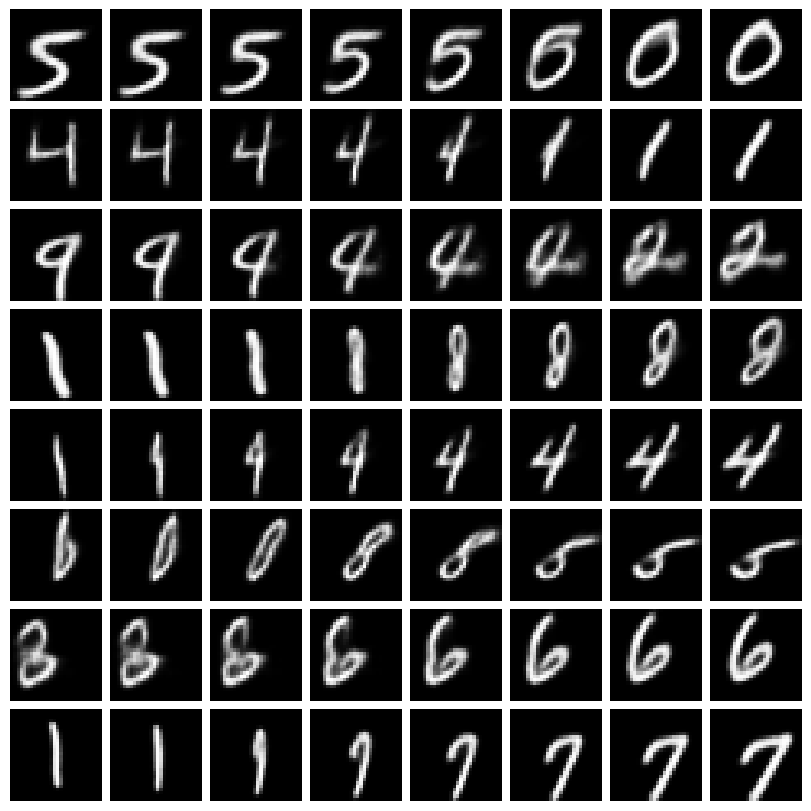

In [59]:
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(pivots_walk.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")

In [101]:
torch.allclose(pivot_walk[-1], pivot2), one.max(), two.max()

(True, tensor(1.), tensor(0.0039))

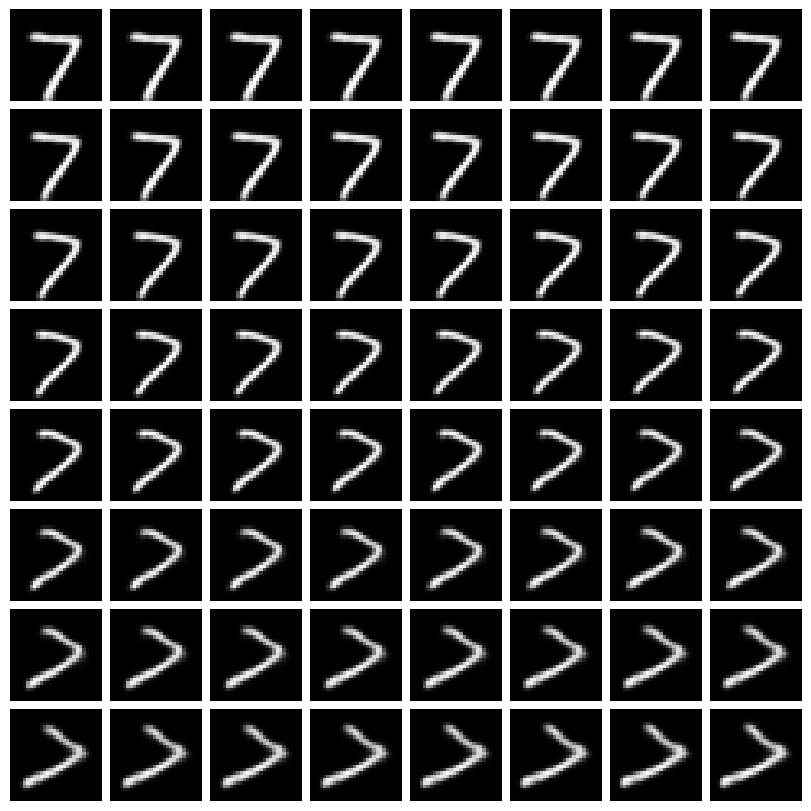

In [104]:
one = test_dataset.data[0] / 255.
two = v2.RandomAffine(degrees=90, translate=(0.,0.))(one.unsqueeze(0)).squeeze() 
model.eval()
with torch.no_grad() : 
    pivot1 = model.encoder(one.unsqueeze(0).unsqueeze(0).cuda())[0].cpu().squeeze()
    pivot2 = model.encoder(two.unsqueeze(0).unsqueeze(0).cuda())[0].cpu().squeeze()

pivot_walk = pivot1 + torch.linspace(0, 1, 64)[:,None]*(pivot2-pivot1)[None,:]

with torch.no_grad():
    generated_imgs = model.decoder(pivot_walk.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs2 = np.array(generated_imgs * 255, dtype=np.uint8).reshape(8, 8, image_size, image_size)
 
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(8, 8)
for n_col in range(8):
    for n_row in range(8):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow(generated_imgs2[n_row, n_col], cmap="gray")
        f_ax.axis("off")
    

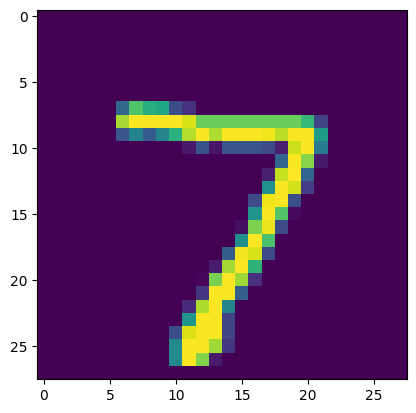

In [98]:
plt.imshow(one)

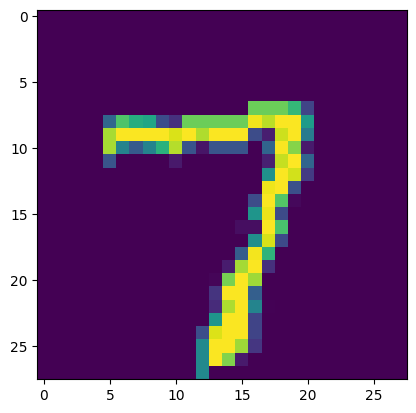

In [99]:
plt.imshow(two)